In [2]:
import uproot as uproot
import hist
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
import os
import subprocess
import pandas as pd

In [7]:
def Event_Combination(Input_Directory, Slice = False, Graph = False, optimize = False, METcut = 0, mjj12cut = 0):
    """
    Takes an input directory with root files, then combines and weights them properly, arranging them in an output dictionary and applying a cut.
    Input_Directory: Defines the directory for which to take event generation files.
    Slice: Defines the slice for which to take data for. 
        Slice False does not slice the data, takes all files without divisions.
        Slice 1 Corresponds to mmjj 1000-4000
        Slice 2 Corresponds to mmjj 4000-7000
        Slice 3 Corresponds to mmjj 7000-10000
        Slice 4 Corresponds to mmjj 10000--1
    Graph: If True displays an example graph of MET average vs individual contribution
    optimize: If True takes into account a third jet.
    METcut: designates the minimum value for the variable MET, all events with lower value will not be included
    mjj12cut: designates the minimum value for the variable mjj calculated using jets 1 and 2.
    
    """
    Directories = os.listdir(Input_Directory)
    TotalEvents = 0
    VBFJet = []
    HistogramArray = []
    PathArray = []
    Branches = []
    CrossSections = []
    MET = []
    METPhi = []
    j1PT = []
    mjj = []
    mjj_13 = []
    mjj_23 = []
    mjjoptimized =[]
    j1Eta = []
    j1Phi = []
    j2PT = []
    j2Eta = []
    j2Phi = []
    Etachange12 = []
    Etachange13 = []
    Etachange23 = []
    j3PT = []
    j3Eta = []
    j3Phi = []
    weight = []
    Scales = []
    MET_Test = []
    Output = {}
    remove = []
    message = "no message"
    #Ignore any background directories not of the current slice
    for item in Directories:
        composite = ["""grep "Cross-section" """+Input_Directory+item+"/docker_mgpy.log"+"| tail -1 | awk '{print $8}'"]
        CrossSectionOutput = subprocess.run(composite, shell=True, capture_output=True)
        #Feel Free to Change the slices.
        if Slice == 1:
            message = "Graph for Slice 1, 1000-4000"
            if "mmjj_1000_4000" in item:
                a=1
            else:
                remove.append(item)
        elif Slice == 2:
            message = "Graph for Slice 2, 4000-7000"
            if "mmjj_4000_7000" in item:
                a=1
            else:
                remove.append(item)
        elif Slice == 3:
            message = "Graph for Slice 3, 7000-10000"
            if "mmjj_7000_10000" in item:
                a=1
            else:
                remove.append(item)
        elif Slice == 4:
            message = "Graph for Slice 4, 10000--1"
            if "mmjj_10000_-1" in item:
                a=1
            else:
                remove.append(item)
        elif Slice == False:
            a=1
            message = "Graph for no slicing scheme"
    print(message)
    for item in set(remove):
        Directories.remove(item)
    remove = []
    #Test Directories to see if they actually contain a valid histogram file
    for item in Directories:
        composite = ["""grep "Cross-section" """+Input_Directory+item+"/docker_mgpy.log"+"| tail -1 | awk '{print $8}'"]
        CrossSectionOutput = subprocess.run(composite, shell=True, capture_output=True)
        if os.path.exists(Input_Directory+item+"/analysis/histograms.root") != True and os.path.exists(Input_Directory+item+"/analysis/SimpleAna.root") != True:
            remove.append(item)
            print("Error, Histogram not found for"+Input_Directory+item+"/analysis/histograms.root")
    #Test Directories to see if they contain a valid Cross Section Output
    for item in Directories:
        composite = ["""grep "Cross-section" """+Input_Directory+item+"/docker_mgpy.log"+"| tail -1 | awk '{print $8}'"]
        CrossSectionOutput = subprocess.run(composite, shell=True, capture_output=True)
        try: 
            z = float(CrossSectionOutput.stdout)
            if type(z) != float:
                remove.append(item)
                Statement = "File "+item+" Unable to be combined, could not find Cross Section"
                print(Statement)
                print(2)
        except:
            remove.append(item)
            Statement = "File "+item+" Unable to be combined, could not find Cross Section"
            print(Statement)
            print(3)
    for item in set(remove):
        Directories.remove(item)
    #Add cross sections and valid histograms to files
    for item in Directories:
        composite = ["""grep "Cross-section" """+Input_Directory+item+"/docker_mgpy.log"+"| tail -1 | awk '{print $8}'"]
        CrossSectionOutput = subprocess.run(composite, shell=True, capture_output=True)
        CrossSections.append(float(CrossSectionOutput.stdout))
        if os.path.exists(Input_Directory+item+"/analysis/histograms.root") == True:
            HistogramArray.append(Input_Directory+item+"/analysis/histograms.root")
        elif os.path.exists(Input_Directory+item+"/analysis/SimpleAna.root") == True:
            HistogramArray.append(Input_Directory+item+"/analysis/SimpleAna.root")
    #Apply a mask cut and add remaining events to output arrays
    for item in HistogramArray:
        PathArray.append(uproot.open(item)['allev/hftree'])
    for item in PathArray:
        Branches.append(item.arrays())
    x=0
    
    for item in Branches:
        #mask = (item[b"mjj"] > 1000)&(item[b"MET"] > 200)&(item[b"njet"] >= 2)&(item[b"nElec"] == 0)&(item[b"nMuon"] == 0)
        mask = (item[b"MET"] > METcut)&(item[b"mjj"] > mjj12cut)&(item[b"njet"] >= 2)&(item[b"nElec"] == 0)&(item[b"nMuon"] == 0)&(item[b"j2PT"] >= 0)&(item[b"j2Eta"] > -50)&(item[b"j2Phi"] > -50)
        for element in item[b"MET"][mask]:
            MET.append(element)
        for element in item[b"METPhi"][mask]:
            METPhi.append(element)
        for element in item[b"j1PT"][mask]:
            j1PT.append(element)
        for element in item[b"mjj"][mask]:
            mjj.append(element)
        for element in item[b"j1Eta"][mask]:
            j1Eta.append(element)
        for element in item[b"j1Phi"][mask]:
            j1Phi.append(element)
        J2PTdummy = 0
        for element in item[b"j2PT"][mask]:
            j2PT.append(element)
            if element > 0:
                J2PTdummy += 1
        J2Etadummy = 0
        for element in item[b"j2Eta"][mask]:
            j2Eta.append(element)
            if element > -50:
                J2Etadummy += 1
        J2Phidummy = 0
        for element in item[b"j2Phi"][mask]:
            j2Phi.append(element)
            if element > -50:
                J2Phidummy += 1
        if optimize == True:
            for element in item[b"mjj_13"][mask]:
                mjj_13.append(element)
            for element in item[b"mjj_23"][mask]:
                mjj_23.append(element)
            for element in item[b"j3PT"][mask]:
                j3PT.append(element)
            for element in item[b"j3Eta"][mask]:
                j3Eta.append(element)
            for element in item[b"j3Phi"][mask]:
                j3Phi.append(element)
    Etachange12 = np.subtract(j1Eta,j2Eta)
    Phichange12 = np.subtract(j1Phi,j2Phi)
    if optimize == True:
        Etachange13 = np.subtract(j1Eta,j3Eta)
        Etachange23 = np.subtract(j2Eta,j3Eta)
        Phichange13 = np.subtract(j1Phi,j3Phi)
        Phichange23 = np.subtract(j2Phi,j3Phi)
    #Take the weights and scale them by number of inputs
    for item in Branches:
        for item in item[b"weight"][mask]:
            if item < 0:
                print(item)
    i=0 
    for item in Branches:
        mask = (item[b"MET"] > METcut)&(item[b"mjj"] > mjj12cut)&(item[b"njet"] >= 2)&(item[b"nElec"] == 0)&(item[b"nMuon"] == 0)&(item[b"j2PT"] >= 0)&(item[b"j2Eta"] > -50)&(item[b"j2Phi"] > -50)
        scale = (CrossSections[i]/sum(item[b"weight"]))
        print(sum(item[b"weight"]))
        i += 1
        Scales.append(scale)
        
        Scaled_weight = item[b"weight"][mask]*scale/len(Directories)
        for item in Scaled_weight:
            weight.append(item)
    TotalEvents = len(MET)
    print(Scales)
    #VBFJet optimization designation
    for i in range(len(mjj)):
        highmass = np.sort([mjj[i],mjj_23[i],mjj_13[i]])
        if highmass[-1] == mjj[i]:
            if j1PT[i] >= j2PT[i]:
                JetHighmass = [1,2]
            else:
                JetHighmass = [1,2]
        if highmass[-1] == mjj_23[i]:
            if j2PT[i] >= j3PT[i]:
                JetHighmass = [2,3]
            else:
                JetHighmass = [3,2]
        if highmass[-1] == mjj_13[i]:
            if j1PT[i] >= j3PT[i]:
                JetHighmass = [1,3]
            else:
                JetHighmass = [3,1]
        
        highEtachange = np.sort([abs(Etachange12[i]),abs(Etachange23[i]),abs(Etachange13[i])])
        if j3PT[i]>0 and j3Eta[i]>-50 and j3Phi[i]>-50:
            if highEtachange[-1] == abs(Etachange12[i]):
                if j1PT[i] >= j2PT[i]:
                    JetHighEtachange = [1,2]
                else:
                    JetHighEtachange = [1,2]
            if highEtachange[-1] == abs(Etachange23[i]):
                if j2PT[i] >= j3PT[i]:
                    JetHighEtachange = [2,3]
                else:
                    JetHighEtachange = [3,2]
            if highEtachange[-1] == abs(Etachange13[i]):
                if j1PT[i] >= j3PT[i]:
                    JetHighEtachange = [1,3]
                else:
                    JetHighEtachange = [3,1]
        else:
            JetHighEtachange = [1,2]
        
        highEtaproduct = np.sort([abs(j1Eta[i]*j2Eta[i]),abs(j2Eta[i]*j3Eta[i]),abs(j1Eta[i]*j3Eta[i])])
        if highEtaproduct[-1] == abs(j1Eta[i]*j2Eta[i]):
            if j1PT[i] >= j2PT[i]:
                JetHighEtaProduct = [1,2]
            else:
                JetHighEtaProduct = [1,2]
        if highEtaproduct[-1] == abs(j2Eta[i]*j3Eta[i]):
            if j2PT[i] >= j3PT[i]:
                JetHighEtaProduct = [2,3]
            else:
                JetHighEtaProduct = [3,2]
        if highEtaproduct[-1] == abs(j1Eta[i]*j3Eta[i]):
            if j1PT[i] >= j3PT[i]:
                JetHighEtaProduct = [1,3]
            else:
                JetHighEtaProduct = [3,1]
        
        highPTproduct = np.sort([abs(j1PT[i]*j2PT[i]),abs(j2PT[i]*j3PT[i]),abs(j1PT[i]*j3PT[i])])
        if highPTproduct[-1] == abs(j1PT[i]*j2PT[i]):
            if j1PT[i] >= j2PT[i]:
                JetHighPTProduct = [1,2]
            else:
                JetHighPTProduct = [1,2]
        if highPTproduct[-1] == abs(j2PT[i]*j3PT[i]):
            if j2PT[i] >= j3PT[i]:
                JetHighPTProduct = [2,3]
            else:
                JetHighPTProduct = [3,2]
        if highPTproduct[-1] == abs(j1PT[i]*j3PT[i]):
            if j1PT[i] >= j3PT[i]:
                JetHighPTProduct = [1,3]
            else:
                JetHighPTProduct = [3,1]
        
        highPhichange = np.sort([abs(Phichange12[i]),abs(Phichange23[i]),abs(Phichange13[i])])
        if highPhichange[-1] == abs(Phichange12[i]):
            if j1PT[i] >= j2PT[i]:
                JetHighPhichange = [1,2]
            else:
                JetHighPhichange = [1,2]
        if highPhichange[-1] == abs(Phichange23[i]):
            if j2PT[i] >= j3PT[i]:
                JetHighPhichange = [2,3]
            else:
                JetHighPhichange = [3,2]
        if highPhichange[-1] == abs(Phichange13[i]):
            if j1PT[i] >= j3PT[i]:
                JetHighPhichange = [1,3]
            else:
                JetHighPhichange = [3,1]
        
        highDeltaR = np.sort([abs((Etachange12[i]**2+Phichange12[i]**2)**0.5),abs((Etachange23[i]**2+Phichange23[i]**2)**0.5),abs((Etachange13[i]**2+Phichange13[i]**2)**0.5)])
        if highDeltaR[-1] == abs((Etachange12[i]**2+Phichange12[i]**2)**0.5):
            if j1PT[i] >= j2PT[i]:
                JetHighDeltaR = [1,2]
            else:
                JetHighDeltaR = [1,2]
        if highDeltaR[-1] == abs((Etachange23[i]**2+Phichange23[i]**2)**0.5):
            if j2PT[i] >= j3PT[i]:
                JetHighDeltaR = [2,3]
            else:
                JetHighDeltaR = [3,2]
        if highDeltaR[-1] == abs((Etachange13[i]**2+Phichange13[i]**2)**0.5):
            if j1PT[i] >= j3PT[i]:
                JetHighDeltaR = [1,3]
            else:
                JetHighDeltaR = [3,1]
        Event = [JetHighmass,JetHighEtachange,JetHighPTProduct,JetHighEtaProduct,JetHighPhichange,JetHighDeltaR]
        
        if JetHighEtachange == [1,3] or JetHighEtachange == [3,1]:
            mjjoptimized.append(mjj_13[i])
        elif JetHighEtachange == [2,3] or JetHighEtachange == [3,2]:
            mjjoptimized.append(mjj_23[i])
        elif JetHighEtachange == [1,2] or JetHighEtachange == [2,1]:
            mjjoptimized.append(mjj[i])
        VBFJet.append(Event)
        Jetsort = JetHighEtachange
        if Jetsort[0] == 1:
            j1PT[i] = j1PT[i]
            j1Eta[i] = j1Eta[i]
            j1Phi[i] = j1Phi[i]
        elif Jetsort[0] == 2:
            j1PT[i] = j2PT[i]
            j1Eta[i] = j2Eta[i]
            j1Phi[i] = j2Phi[i]
        elif Jetsort[0] == 3:
            j1PT[i] = j3PT[i]
            j1Eta[i] = j3Eta[i]
            j1Phi[i] = j3Phi[i]
        if Jetsort[1] == 1:
            j2PT[i] = j1PT[i]
            j2Eta[i] = j1Eta[i]
            j2Phi[i] = j1Phi[i]
        elif Jetsort[1] == 2:
            j2PT[i] = j2PT[i]
            j2Eta[i] = j2Eta[i]
            j2Phi[i] = j2Phi[i]
        elif Jetsort[1] == 3:
            j2PT[i] = j3PT[i]
            j2Eta[i] = j3Eta[i]
            j2Phi[i] = j3Phi[i]
    #Use this Output function to implement and variables you want to calculate from this Combination Function
    Output = {"Directories":Directories, "Number of Events":TotalEvents,
              "Cross Sections":CrossSections, "MET":MET, "METPhi":METPhi, "j1PT":j1PT, 
              "mjj":mjj,"mjj_13":mjj_13, "mjj_23":mjj_23, "mjjoptimized":mjjoptimized, "j1Eta":j1Eta,
              "j1Phi":j1Phi, "j2PT":j2PT, "j2Eta":j2Eta, "j2Phi":j2Phi,
              "j3Eta":j1Eta,"j3Phi":j1Phi, "j3PT":j3PT, "weight":weight,
              "Etachange12":Etachange12,"Etachange13":Etachange13,"Etachange23":Etachange23,
              "VBFJet":VBFJet}
    #graph a sample graph of items vs their background, averages vs individual inputs.
    if Graph == True:
        MET_ModifiedBranches = []
        for item in Branches:
            mask = (item[b"MET"] > METcut)&(item[b"mjj"] > mjj12cut)&(item[b"njet"] >= 2)&(item[b"nElec"] == 0)&(item[b"nMuon"] == 0)&(item[b"j2PT"] >= 0)&(item[b"j2Eta"] > -50)&(item[b"j2Phi"] > -50)
            masked = item[b"MET"][mask]
            MET_ModifiedBranches.append(masked)
        Weights = []
        for item in Branches:
            mask = (item[b"MET"] > METcut)&(item[b"mjj"] > mjj12cut)&(item[b"njet"] >= 2)&(item[b"nElec"] == 0)&(item[b"nMuon"] == 0)&(item[b"j2PT"] >= 0)&(item[b"j2Eta"] > -50)&(item[b"j2Phi"] > -50)
            maskedbackground = item[b"weight"][mask]
            Weights.append(maskedbackground)
        for i in range(len(MET_ModifiedBranches)):
            plt.hist(MET_ModifiedBranches[i],bins=100,range=(0,2000),weights = Weights[i]*Scales[i], alpha=0.025, color='black')
        plt.hist(MET,bins=100,range=(0,2000),weights = weight, alpha=0.3, color='purple')
        plt.yscale('log')
        plt.title("Met Comparison, Inputs (Grey) vs Averaged Output (Purple); "+message)
        plt.show()

    return(Output)

In [11]:
def Background(Input_Directory, Graph = False, optimize = False, METcut = 0, mjj12cut = 0):
    """
    Takes a directory of background events, sorts them by slice, averages over each slice, then combines into one output. Applies a cut.
    Input_Directory: The directory you wish to input to average over, really only works with a background directory.
    Graph: If true displays a test graph of average vs individual contribution for each slice.
    optimize: determines if a third jet is available to be used.
    """
    Directories = []
    VBFJet = []
    TotalEvents = 0
    CrossSections = []
    MET = []
    METPhi = []
    j1PT = []
    mjj = []
    mjj_13 = []
    mjj_23 = []
    mjjoptimized = []
    j1Eta = []
    j1Phi = []
    j2PT = []
    j2Eta = []
    j2Phi = []
    Etachange12 = []
    Etachange13 = []
    Etachange23 = []
    j3PT = []
    j3Eta = []
    j3Phi = []
    weight = []
    Dummy = []
    Output = {}
    Slices = [1, 2, 3, 4]
    for item in Slices:
        partition = Event_Combination(Input_Directory, Slice = item, Graph = Graph, optimize = optimize, METcut = METcut, mjj12cut = mjj12cut)
        for item in partition["Directories"]:
            Directories.append(item)
        TotalEvents += partition["Number of Events"]
        for item in partition["Cross Sections"]:
            CrossSections.append(item)
        for item in partition["MET"]: 
            MET.append(item)
        for item in partition["METPhi"]: 
            METPhi.append(item)
        for item in partition["j1PT"]: 
            j1PT.append(item)
        for item in partition["mjj"]: 
            mjj.append(item)
        for item in partition["j1Eta"]: 
            j1Eta.append(item)
        for item in partition["j1Phi"]: 
            j1Phi.append(item)
        for item in partition["j2PT"]: 
            j2PT.append(item)
        for item in partition["j2Eta"]: 
            j2Eta.append(item)
        for item in partition["j2Phi"]: 
            j2Phi.append(item)
        for item in partition["Etachange12"]:
            Etachange12.append(item)
        for item in partition["Etachange13"]:
            Etachange13.append(item)
        for item in partition["Etachange23"]:
            Etachange23.append(item)
        if optimize == True:
            for item in partition["mjjoptimized"]: 
                mjjoptimized.append(item)
            for item in partition["mjj_13"]: 
                mjj_13.append(item)
            for item in partition["mjj_23"]: 
                mjj_23.append(item)
            for item in partition["j3PT"]: 
                j3PT.append(item)
            for item in partition["j3Eta"]: 
                j3Eta.append(item)
            for item in partition["j3Phi"]: 
                j3Phi.append(item)
        for item in partition["weight"]: 
            weight.append(item)
        for item in partition["VBFJet"]: 
            VBFJet.append(item)

            
        
    Output = {"Directories":Directories, "Number of Events":TotalEvents,
              "Cross Sections": CrossSections, "MET": MET, "METPhi":METPhi, "j1PT":j1PT, 
              "mjj":mjj,"mjj_13":mjj_13, "mjj_23":mjj_23,"mjjoptimized":mjjoptimized, "j1Eta":j1Eta,
              "j1Phi":j1Phi, "j2PT":j2PT, "j2Eta":j2Eta, "j2Phi":j2Phi,
              "j3Eta":j1Eta,"j3Phi":j1Phi, "j3PT":j3PT, "weight":weight,
              "Etachange12":Etachange12,"Etachange13":Etachange13,"Etachange23":Etachange23,
              "VBFJet":VBFJet}
    return(Output)

In [19]:
EWKBDirect = "/data/users/jupyter-blonsbro/SUSY/Generations/13TeV/Background/EWKBackground/"
QCDBDirect = "/data/users/jupyter-blonsbro/SUSY/Generations/13TeV/Background/QCDBackground/"
SignalDirectory = "/data/users/jupyter-blonsbro/SUSY/Generations/13TeV/Signal/150mjj/"
A = Event_Combination(SignalDirectory, Graph = True, optimize = True, METcut = 0,mjj12cut = 0)

Graph for no slicing scheme
4545.8001076206565
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217744112
-0.0227960217

TypeError: 'float' object is not subscriptable

In [16]:
A[0]['weight']

[3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.876874377084505e-09,
 3.8768743770845

In [14]:
s_MET = A[0]['MET']
s_j1PT = A[0]['j1PT']
s_j1Eta = A[0]['j1Eta']
s_j1Phi = A[0]['j1Phi']
s_j2PT = A[0]['j2PT']
s_j2Eta = A[0]['j2Eta']
s_j2Phi = A[0]['j2Phi']
s_METPhi = A[0]['METPhi']
s_weight = A[0]['weight']
s_j3PT = A[0]['j3PT']
s_j3Eta = A[0]['j3Eta']
s_j3Phi = A[0]['j3Phi']

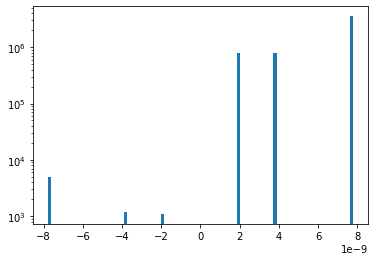

In [15]:
plt.hist(s_weight, bins=100)
plt.yscale('log')

In [ ]:
plt.title('MET & Combined Backgrounds')
plt.hist(s_MET, bins=100, weights=s_weight, range=(200,3000), alpha=0.5, color='orange', label='Signal MET')
plt.yscale('log')
plt.legend()
plt.show()

Graph for Slice 1, 1000-4000
690059.9839468002
[6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, ... 6.92, 6.92, 6.92, 6.92, 6.92, 6.92]
690900.0244140625
[691, 691, 691, 691, 691, 691, 691, 691, ... 691, 691, 691, 691, 691, 691, 691, 691]
691319.9969143867
[3.47, 3.47, 3.47, 3.47, 3.47, 3.47, 3.47, ... 3.47, 3.47, 3.47, 3.47, 3.47, 3.47]
691460.0157215595
[0.693, 0.693, 0.693, 0.693, 0.693, 0.693, ... 0.693, 0.693, 0.693, 0.693, 0.693]
691740.0145831108
[3.47, 3.47, 3.47, 3.47, 3.47, 3.47, 3.47, ... 3.47, 3.47, 3.47, 3.47, 3.47, 3.47]
690900.0091562271
[3.46, 3.46, 3.46, 3.46, 3.46, 3.46, 3.46, ... 3.46, 3.46, 3.46, 3.46, 3.46, 3.46]
691460.0147771835
[6.93, 6.93, 6.93, 6.93, 6.93, 6.93, 6.93, ... 6.93, 6.93, 6.93, 6.93, 6.93, 6.93]
690620.0081691742
[6.92, 6.92, 6.92, 6.92, 6.92, 6.92, 6.92, ... 6.92, 6.92, 6.92, 6.92, 6.92, 6.92]
691879.9930934906
[6.93, 6.93, 6.93, 6.93, 6.93, 6.93, 6.93, ... 6.93, 6.93, 6.93, 6.93, 6.93, 6.93]
690619.9983911514
[3.46, 3.46, 3.46, 3.46, 3.46, 3.46, 3.46, 

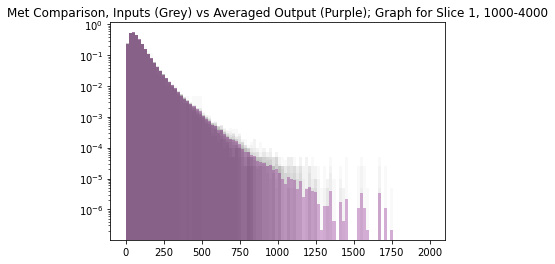

Graph for Slice 2, 4000-7000
11585.00005916506
[0.0589, 0.0589, 0.0589, 0.0589, 0.0589, ... 0.0589, 0.0589, 0.0589, 0.0589, 0.0589]
11589.200143158436
[0.0118, 0.0118, 0.0118, 0.0118, 0.0118, ... 0.0118, 0.0118, -0.0118, 0.0118, 0.0118]
11573.800081759691
[0.118, 0.118, 0.118, 0.118, 0.118, 0.118, ... 0.118, 0.118, 0.118, 0.118, 0.118]
11571.000283300877
[0.118, 0.118, 0.118, 0.118, -0.118, 0.118, ... 0.118, 0.118, 0.118, 0.118, 0.118]
11589.20009559393
[0.059, 0.059, 0.059, 0.059, 0.059, 0.059, ... 0.059, 0.059, 0.059, 0.059, -0.059]
11579.40005299449
[0.059, 0.059, 0.059, 0.059, 0.059, 0.059, ... 0.059, 0.059, 0.059, 0.059, 0.059]
11562.599961742759
[0.0589, 0.0589, 0.0589, 0.0589, 0.0589, ... 0.0589, 0.0589, 0.0589, 0.0589, 0.0589]
11579.400067433715
[0.118, 0.118, 0.118, 0.118, 0.118, 0.118, ... 0.118, 0.118, 0.118, 0.118, 0.118]
11561.199781477451
[0.118, 0.118, 0.118, 0.118, 0.118, 0.118, ... 0.118, 0.118, 0.118, 0.118, 0.118]
11582.199579156935
[0.0118, 0.0118, 0.0118, 0.0118, 0

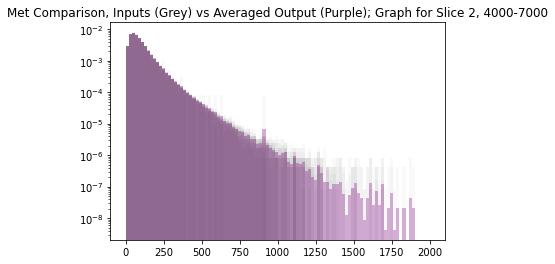

Graph for Slice 3, 7000-10000
80.09400023485068
[0.000839, 0.000839, 0.000839, 0.000839, ... 0.000839, 0.000839, 0.000839, 0.000839]
80.12199919321574
[0.000839, 0.000839, 0.000839, 0.000839, ... 0.000839, 0.000839, 0.000839, 0.000839]
80.29000100842677
[0.000419, 0.000419, 0.000419, 0.000419, ... 0.000419, 0.000419, 0.000419, -0.000419]
80.34599924844224
[-0.00042, 0.00042, 0.00042, 0.00042, ... 0.00042, 0.00042, 0.00042, 0.00042]
80.24800019583199
[0.00084, 0.00084, 0.00084, 0.00084, 0.00084, ... 0.00084, 0.00084, 0.00084, 0.00084]
80.2339983942802
[0.00042, 0.00042, 0.00042, 0.00042, 0.00042, ... 0.00042, 0.00042, 0.00042, 0.00042]
80.22000085719628
[0.00042, 0.00042, 0.00042, 0.00042, 0.00042, ... 0.00042, 0.00042, 0.00042, 0.00042]
79.58999873697758
[0.0831, 0.0831, 0.0831, 0.0831, 0.0831, ... 0.0831, 0.0831, 0.0831, 0.0831, 0.0831]
80.29000046895817
[0.000839, 0.000839, 0.000839, 0.000839, ... 0.000839, 0.000839, 0.000839, 0.000839]
80.23400028655306
[0.00042, 0.00042, 0.00042, 0

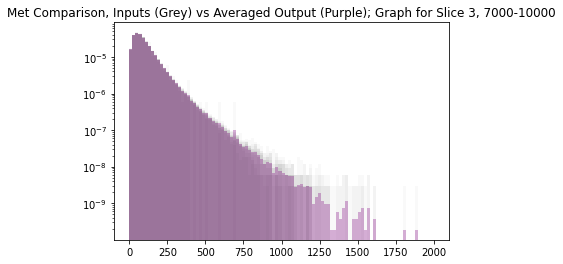

Graph for Slice 4, 10000--1
0.052584000426577404
[5.67e-07, 5.67e-07, 5.67e-07, 5.67e-07, ... 5.67e-07, 5.67e-07, 5.67e-07, 5.67e-07]
0.05279400125425582
[2.85e-07, -2.85e-07, 2.85e-07, 2.85e-07, ... 2.85e-07, 2.85e-07, 2.85e-07, 2.85e-07]
0.052471997507041124
[5.67e-07, 5.67e-07, 5.67e-07, 5.67e-07, ... 5.67e-07, 5.67e-07, 5.67e-07, 5.67e-07]
0.05283599868585043
[2.86e-07, 2.86e-07, 2.86e-07, 2.86e-07, ... 2.86e-07, 2.86e-07, 2.86e-07, 2.86e-07]
0.05283599965218855
[2.86e-07, 2.86e-07, 2.86e-07, 2.86e-07, ... 2.86e-07, 2.86e-07, 2.86e-07, 2.86e-07]
0.052892000723829824
[2.86e-07, -2.86e-07, 2.86e-07, 2.86e-07, ... 2.86e-07, 2.86e-07, 2.86e-07, 2.86e-07]
0.05242999851634522
[5.69e-07, 5.69e-07, 5.69e-07, 5.69e-07, ... 5.69e-07, 5.69e-07, 5.69e-07, -5.69e-07]
0.051884000800782815
[5.54e-05, 5.54e-05, 5.54e-05, 5.54e-05, ... 5.54e-05, 5.54e-05, 5.54e-05, -5.54e-05]
0.052724000775469904
[5.71e-07, 5.71e-07, 5.71e-07, 5.71e-07, ... 5.71e-07, 5.71e-07, 5.71e-07, 5.71e-07]
0.0527380016056326

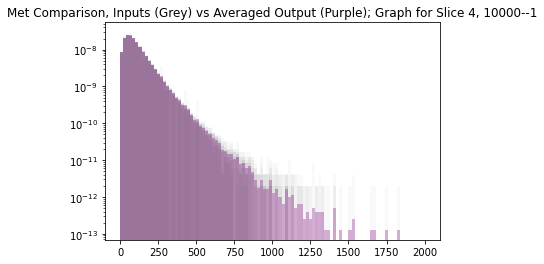

Graph for Slice 1, 1000-4000
6211800.120353699
[62.3, 62.3, 62.3, 62.3, 62.3, 62.3, 62.3, ... 62.3, 62.3, 62.3, 62.3, 62.3, 62.3]
6228599.8671875
[6.24e+03, 6.24e+03, 6.24e+03, 6.24e+03, ... 6.24e+03, 6.24e+03, 6.24e+03, 6.24e+03]
6210399.9443740845
[6.23, 6.23, 6.23, 6.23, 6.23, 6.23, 6.23, ... 6.23, 6.23, 6.23, 6.23, 6.23, 6.23]
6210400.063049316
[62.3, 62.3, 62.3, 62.3, 62.3, 62.3, 62.3, ... 62.3, 62.3, 62.3, 62.3, 62.3, 62.3]
6197799.8592681885
[62.2, 62.2, 62.2, 62.2, 62.2, 62.2, 62.2, ... 62.2, 62.2, 62.2, 62.2, 62.2, 62.2]
6189399.893493652
[62.1, 62.1, 62.1, 62.1, 62.1, 62.1, 62.1, ... 62.1, 62.1, 62.1, 62.1, 62.1, 62.1]
6207599.961080551
[6.23, 6.23, 6.23, 6.23, 6.23, 6.23, 6.23, ... 6.23, 6.23, 6.23, 6.23, 6.23, 6.23]
6195000.099319458
[62.2, 62.2, 62.2, 62.2, 62.2, 62.2, 62.2, ... 62.2, 62.2, 62.2, 62.2, 62.2, 62.2]
6210399.81404686
[6.23, 6.23, 6.23, 6.23, 6.23, 6.23, 6.23, ... 6.23, 6.23, 6.23, 6.23, 6.23, 6.23]
6208999.8599796295
[6.23, 6.23, 6.23, 6.23, 6.23, 6.23, 6.23,

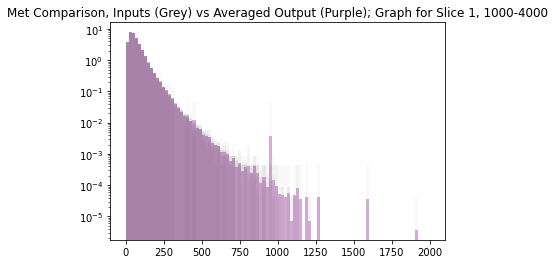

Graph for Slice 2, 4000-7000
10470.599963510409
[0.0107, 0.0107, 0.0107, 0.0107, 0.0107, ... 0.0107, 0.0107, 0.0107, 0.0107, 0.0107]
10458.000325784087
[0.107, 0.107, 0.107, 0.107, 0.107, 0.107, ... 0.107, 0.107, 0.107, 0.107, 0.107]
10474.800099134445
[0.108, 0.108, 0.108, 0.108, 0.108, 0.108, ... 0.108, 0.108, 0.108, 0.108, 0.108]
10466.40002296865
[0.107, 0.107, 0.107, 0.107, 0.107, 0.107, ... 0.107, 0.107, 0.107, 0.107, 0.107]
10455.200328931212
[0.107, 0.107, 0.107, 0.107, 0.107, 0.107, ... 0.107, 0.107, 0.107, 0.107, 0.107]
10474.799603022635
[0.0191, 0.0191, 0.0191, 0.0191, 0.0191, ... 0.0191, 0.0191, 0.0191, 0.0191, 0.0191]
10386.600341796875
[10.6, 10.6, 10.6, 10.6, -10.6, 10.6, 10.6, ... 10.6, 10.6, 10.6, 10.6, 10.6, 10.6]
10456.599832512438
[0.12, 0.12, -0.12, 0.12, 0.12, 0.12, 0.12, ... 0.12, 0.12, 0.12, 0.12, 0.12, 0.12]
10470.599996566772
[0.108, 0.108, 0.108, 0.108, 0.108, 0.108, ... 0.108, 0.108, 0.108, 0.108, 0.108]
10467.799742221832
[0.139, 0.139, 0.139, 0.139, 0.139

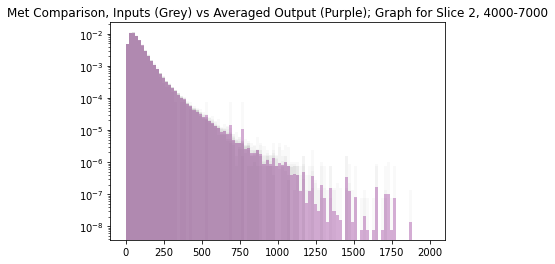

Graph for Slice 3, 7000-10000
19.306000067212153
[0.000207, 0.000207, 0.000207, 0.000207, ... 0.000207, 0.000207, 0.000207, 0.000207]
19.278000413556583
[0.000207, 0.000207, 0.000207, 0.000207, ... 0.000207, -0.000207, 0.000207, 0.000207]
19.29199967929162
[0.000207, 0.000207, 0.000207, 0.000207, ... 0.000207, 0.000207, 0.000207, 0.000207]
19.306000317446887
[0.000207, 0.000207, 0.000207, 0.000207, ... 0.000207, 0.000207, 0.000207, -0.000207]
19.33400003996212
[0.000207, 0.000207, 0.000207, 0.000207, ... 0.000207, 0.000207, 0.000207, 0.000207]
19.305999350501224
[0.000207, 0.000207, 0.000207, 0.000207, ... 0.000207, 0.000207, 0.000207, -0.000207]
19.291999671258964
[0.000207, 0.000207, 0.000207, 0.000207, ... 0.000207, 0.000207, 0.000207, 0.000207]
19.404000628739595
[0.021, 0.021, 0.021, 0.021, 0.021, 0.021, ... 0.021, 0.021, 0.021, 0.021, 0.021]


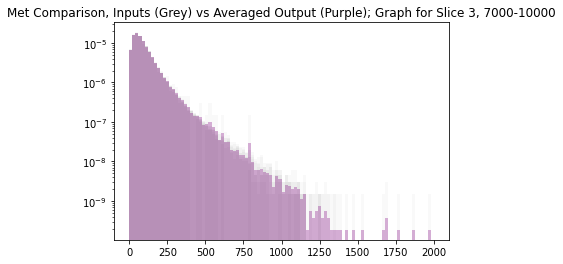

Graph for Slice 4, 10000--1
File VjjQCD_13_mmjj_10000_-1_1007 Unable to be combined, could not find Cross Section
3
0.0034622000891459948
[4.37e-08, 4.37e-08, 4.37e-08, 4.37e-08, ... 4.37e-08, 4.37e-08, 4.37e-08, 4.37e-08]
0.0034566000376230477
[4.34e-08, 4.34e-08, 4.34e-08, 4.34e-08, ... 4.34e-08, 4.34e-08, 4.34e-08, 4.34e-08]
0.003455199983520174
[4.37e-08, 4.37e-08, -4.37e-08, 4.37e-08, ... 4.37e-08, 4.37e-08, 4.37e-08, 4.37e-08]
0.0034579998777601872
[4.32e-08, 4.32e-08, 4.32e-08, 4.32e-08, ... 4.32e-08, 4.32e-08, 4.32e-08, -4.32e-08]
0.0034607998747162583
[4.36e-08, 4.36e-08, 4.36e-08, 4.36e-08, ... 4.36e-08, 4.36e-08, -4.36e-08, 4.36e-08]
0.003456599861138443
[4.36e-08, 4.36e-08, 4.36e-08, 4.36e-08, ... -4.36e-08, 4.36e-08, -4.36e-08]
0.0034328001656831475
[4.26e-06, 4.26e-06, 4.26e-06, 4.26e-06, ... 4.26e-06, 4.26e-06, 4.26e-06, 4.26e-06]


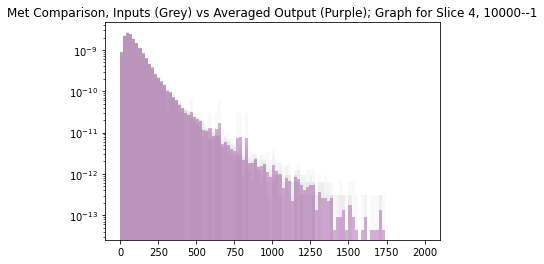

In [5]:
B = Background(EWKBDirect, Graph = True, optimize = True, METcut = 0)
C = Background(QCDBDirect, Graph = True, optimize = True, METcut = 0)

Graph for no slicing scheme
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.045653700828552246
-0.0

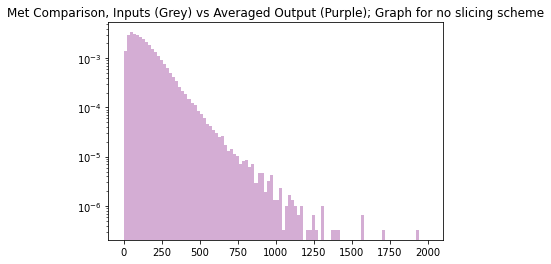

Graph for Slice 1, 1000-4000
690900.0244140625
[7.142856890452808e-06]


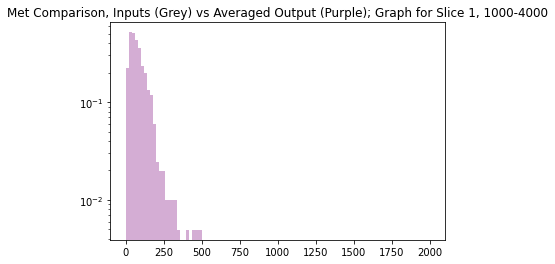

Graph for Slice 2, 4000-7000
-11.648056983947754
-11.648056983947754
-11.648056983947754
-11.648056983947754
-11.648056983947754
-11.648056983947754
11391.799730300903
[7.142857311963181e-06]


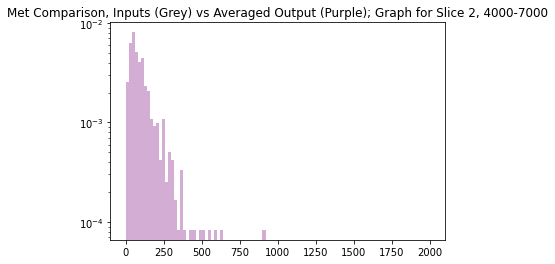

Graph for Slice 3, 7000-10000
-0.08307933062314987
-0.08307933062314987
-0.08307933062314987
-0.08307933062314987
-0.08307933062314987
-0.08307933062314987
-0.08307933062314987
79.58999873697758
[7.142857256207927e-06]


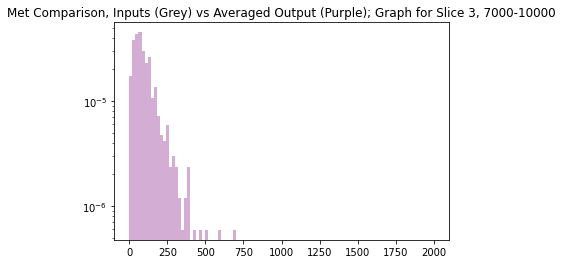

Graph for Slice 4, 10000--1
-5.543162478716113e-05
-5.543162478716113e-05
-5.543162478716113e-05
-5.543162478716113e-05
-5.543162478716113e-05
-5.543162478716113e-05
-5.543162478716113e-05
-5.543162478716113e-05
-5.543162478716113e-05
-5.543162478716113e-05
-5.543162478716113e-05
-5.543162478716113e-05
-5.543162478716113e-05
-5.543162478716113e-05
-5.543162478716113e-05
-5.543162478716113e-05
-5.543162478716113e-05
0.051884000800782815
[7.142857032613577e-06]


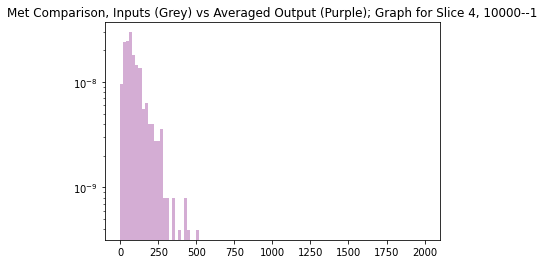

Graph for Slice 1, 1000-4000
6228599.8671875
[7.14285729516436e-06]


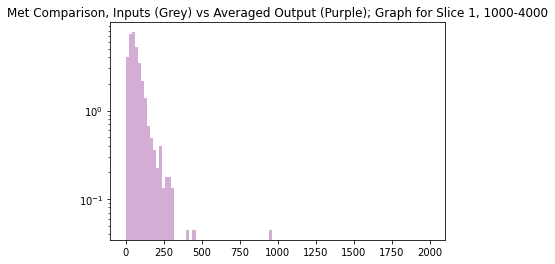

Graph for Slice 2, 4000-7000
-10.59857177734375
-10.59857177734375
-10.59857177734375
-10.59857177734375
-10.59857177734375
-10.59857177734375
-10.59857177734375
-10.59857177734375
10386.600341796875
[7.142856907803693e-06]


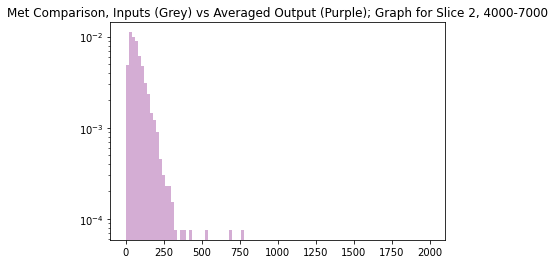

Graph for Slice 3, 7000-10000
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
-0.020954644307494164
19.404000628739595
[7.142856911410176e-06]


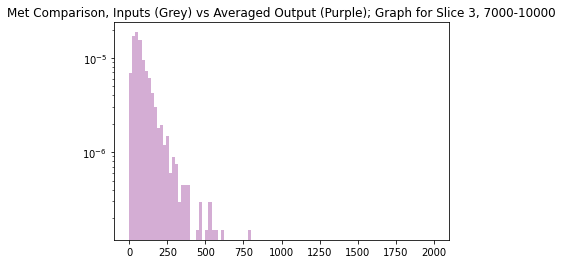

Graph for Slice 4, 10000--1
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.2590572775225155e-06
-4.259057277

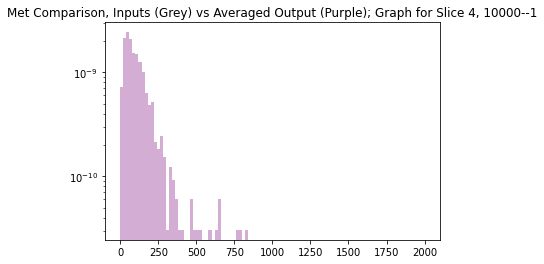

In [12]:
EWKBDirect1 = "/data/users/jupyter-blonsbro/SUSY/Generations/13TeV/Background/EWKBackground/testfile/"
QCDBDirect1 = "/data/users/jupyter-blonsbro/SUSY/Generations/13TeV/Background/QCDBackground/testfile/"
SignalDirectory1 = "/data/users/jupyter-blonsbro/SUSY/Generations/13TeV/Signal/150mjj/testfile/"
D = Event_Combination(SignalDirectory1, Graph = True, optimize = True, METcut = 0,mjj12cut = 0)
E = Background(EWKBDirect1, Graph = True, optimize = True, METcut = 0)
F = Background(QCDBDirect1, Graph = True, optimize = True, METcut = 0)

In [16]:
#Create Directories to be cut and pushed into files
SD = dict((k, A[k]) for k in ['MET',"METPhi","j1PT","mjj","mjj_13","mjj_23","mjjoptimized","j1Eta","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT","weight"]
                                       if k in A)
SDEvents = pd.DataFrame.from_dict(SD)
#SDEvents = pd.DataFrame.from_dict(SD)
EWKBD = dict((k, B[k]) for k in ['MET',"METPhi","j1PT","mjj","mjj_13","mjj_23","mjjoptimized","j1Eta","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT","weight"]
                                       if k in B)
EWKBDEvents = pd.DataFrame.from_dict(EWKBD)
QCDBD = dict((k, C[k]) for k in ['MET',"METPhi","j1PT","mjj","mjj_13","mjj_23","mjjoptimized","j1Eta","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT","weight"]
                                       if k in C)
QCDBDEvents = pd.DataFrame.from_dict(QCDBD)

In [15]:
#Create Directories to be cut and pushed into files
SD1 = dict((k, D[k]) for k in ['MET',"METPhi","j1PT","mjj","mjj_13","mjj_23","mjjoptimized","j1Eta","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT","weight"]
                                       if k in D)
SDEvents1 = pd.DataFrame.from_dict(SD1)

EWKBD1 = dict((k, E[k]) for k in ['MET',"METPhi","j1PT","mjj","mjj_13","mjj_23","mjjoptimized","j1Eta","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT","weight"]
                                       if k in E)
EWKBDEvents1 = pd.DataFrame.from_dict(EWKBD1)
QCDBD1 = dict((k, F[k]) for k in ['MET',"METPhi","j1PT","mjj","mjj_13","mjj_23","mjjoptimized","j1Eta","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT","weight"]
                                       if k in F)
QCDBDEvents1 = pd.DataFrame.from_dict(QCDBD1)

In [17]:
SD

{'MET': [130.3594970703125,
  100.90216064453125,
  57.3304557800293,
  60.23020553588867,
  241.0147247314453,
  172.3428955078125,
  215.4097900390625,
  89.4819107055664,
  83.57608032226562,
  34.580406188964844,
  81.13138580322266,
  184.63836669921875,
  192.96669006347656,
  54.719635009765625,
  119.08995819091797,
  308.335693359375,
  137.47769165039062,
  73.39215087890625,
  132.67593383789062,
  306.3349304199219,
  186.0068359375,
  99.00364685058594,
  158.8359832763672,
  32.26315689086914,
  163.5211944580078,
  100.32091522216797,
  30.219890594482422,
  185.73265075683594,
  152.2703094482422,
  234.84007263183594,
  42.95322036743164,
  299.8505859375,
  117.42259216308594,
  267.4127197265625,
  716.7898559570312,
  214.25531005859375,
  84.41374206542969,
  213.3623046875,
  101.78085327148438,
  183.3147735595703,
  130.3563232421875,
  333.2000732421875,
  36.33892059326172,
  126.43502807617188,
  102.06095123291016,
  17.826457977294922,
  39.53073501586914,


In [18]:
#Create file of events with no cuts applied
file1 = uproot.recreate("Combined Signal Ntuples.root")
file1["Signal"] = SDEvents 
file2 = uproot.recreate("Combined EWKBackground Ntuples.root")
file2["EWKBackground"] = EWKBDEvents
file3 = uproot.recreate("Combined QCDBackground Ntuples.root")
file3["QCDBackground"] = QCDBDEvents

In [17]:
testfile1 = uproot.recreate("Combined Signal Ntuples1.root")
testfile1["Signal"] = SDEvents1 
testfile2 = uproot.recreate("Combined EWKBackground Ntuples1.root")
testfile2["EWKBackground"] = EWKBDEvents1
testfile3 = uproot.recreate("Combined QCDBackground Ntuples1.root")
testfile3["QCDBackground"] = QCDBDEvents1

In [19]:
#Create file of events with mjj>1000, MET>200, and 3 jets.
file1 = uproot.recreate("Combined Signal Ntuples, mjj>1000, MET>200, 3 jets.root")
#The j3Eta cut ensures no j3Eta values in the -1000 range, indicative of an error, most are around 1.
file1["Signal"] = SDEvents.loc[(SDEvents['mjjoptimized'] > 1000) & (SDEvents['MET'] > 200)]
file2 = uproot.recreate("Combined EWKBackground Ntuples, mjj>1000, MET>200, 3 jets.root")
file2["EWKBackground"] = EWKBDEvents.loc[(EWKBDEvents['mjjoptimized'] > 1000) & (EWKBDEvents['MET'] > 200)]
file3 = uproot.recreate("Combined QCDBackground Ntuples, mjj>1000, MET>200, 3 jets.root")
file3["QCDBackground"] = QCDBDEvents.loc[(QCDBDEvents['mjjoptimized'] > 1000) & (QCDBDEvents['MET'] > 200)]

In [20]:
file1 = uproot.recreate("Combined Signal Ntuples, mjj>1000, MET>100, 3 jets.root")
file1["Signal"] = SDEvents.loc[(SDEvents['mjjoptimized'] > 1000) & (SDEvents['MET'] > 100)]
file2 = uproot.recreate("Combined EWKBackground Ntuples, mjj>1000, MET>100, 3 jets.root")
file2["EWKBackground"] = EWKBDEvents.loc[(EWKBDEvents['mjjoptimized'] > 1000) & (EWKBDEvents['MET'] > 100)]
file3 = uproot.recreate("Combined QCDBackground Ntuples, mjj>1000, MET>100, 3 jets.root")
file3["QCDBackground"] = QCDBDEvents.loc[(QCDBDEvents['mjjoptimized'] > 1000) & (QCDBDEvents['MET'] > 100)]

In [21]:
file1 = uproot.recreate("Combined Signal Ntuples, 2 jets.root")
file1["Signal"] = SDEvents.loc[SDEvents['j2Eta'] > -50]
file2 = uproot.recreate("Combined EWKBackground Ntuples, 2 jets.root")
file2["EWKBackground"] = EWKBDEvents
file3 = uproot.recreate("Combined QCDBackground Ntuples, 2 jets.root")
file3["QCDBackground"] = QCDBDEvents

In [65]:
#Define Variables to Graph
S_j1PT = A["j1PT"]
B_j1PT = np.append(B["j1PT"],C["j1PT"])
S_weight = A["weight"]
B_weight = np.append(B["weight"],C["weight"])
S_MET = A["MET"]
B_MET = np.append(B["MET"],C["MET"])
S_mjj = A["mjj"]
B_mjj = np.append(B["mjj"],C["mjj"])
S_j1Eta = A["j1Eta"]
B_j1Eta = np.append(B["j1Eta"],C["j1Eta"])
S_j1Phi = A["j1Phi"]
B_j1Phi = np.append(B["j1Phi"],C["j1Phi"])
S_j2PT = A["j2PT"]
B_j2PT = np.append(B["j2PT"],C["j2PT"])
S_j2Eta = A["j2Eta"]
B_j2Eta = np.append(B["j2Eta"],C["j2Eta"])
S_j2Phi = A["j2Phi"]
B_j2Phi = np.append(B["j2Phi"],C["j2Phi"])
S_j3PT = A["j3PT"]
B_j3PT = np.append(B["j3PT"],C["j3PT"])
S_j3Eta = A["j3Eta"]
B_j3Eta = np.append(B["j3Eta"],C["j3Eta"])
S_j3Phi = A["j3Phi"]
B_j3Phi = np.append(B["j3Phi"],C["j3Phi"])
S_Etachange12 = A["Etachange12"]
B_Etachange12 = np.append(B["Etachange12"],C["Etachange12"])
S_Etachange23 = A["Etachange23"]
B_Etachange23 = np.append(B["Etachange23"],C["Etachange23"])
S_Etachange13 = A["Etachange13"]
B_Etachange13 = np.append(B["Etachange13"],C["Etachange13"])

In [9]:
S_mjjoptimized = A["mjjoptimized"]
B_mjjoptimized = np.append(B["mjjoptimized"],C["mjjoptimized"])

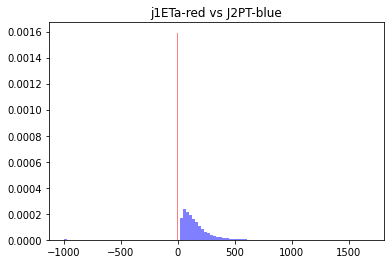

In [15]:
plt.hist(S_j1Eta, bins=100,range=(min(S_j1Eta),max(S_j1Eta)), weights=S_weight, alpha=0.5, color = 'red')
plt.hist(S_j2PT, bins=100, weights=S_weight, alpha=0.5, color = 'blue')
plt.title("j1ETa-red vs J2PT-blue")
plt.show()

In [38]:
np.corrcoef(S_j1Eta,S_j2PT)

/opt/tljh/user/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/tljh/user/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([[ 1., nan],
       [nan, nan]])

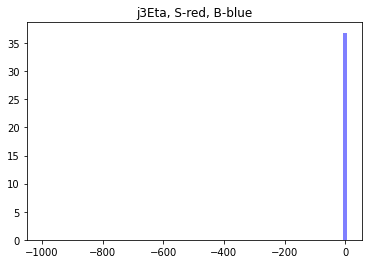

In [66]:
plt.hist(S_j3Eta, bins=100,range=(min(S_j3Eta),max(S_j3Eta)), weights=S_weight, alpha=0.5, color = 'red')
plt.hist(B_j3Eta, bins=100,range=(min(B_j3Eta),max(B_j3Eta)), weights=B_weight, alpha=0.5, color = 'blue')
plt.title("j3Eta, S-red, B-blue")
plt.show()

In [68]:
n = 0
for i in range(len(A["MET"])):
    if A["j2Eta"][i] <-50:
        print(i)
        print(A["j2Eta"][i])
print(n)

75
-999.0
803
-999.0
1394
-999.0
1647
-999.0
1756
-999.0
2235
-999.0
2417
-999.0
2726
-999.0
2781
-999.0
2791
-999.0
3421
-999.0
3792
-999.0
3955
-999.0
3958
-999.0
4528
-999.0
4542
-999.0
4852
-999.0
4853
-999.0
6006
-999.0
6069
-999.0
6143
-999.0
6209
-999.0
6771
-999.0
7235
-999.0
7274
-999.0
8391
-999.0
8688
-999.0
9111
-999.0
9354
-999.0
9687
-999.0
9747
-999.0
9803
-999.0
10730
-999.0
10761
-999.0
10838
-999.0
11215
-999.0
11397
-999.0
11905
-999.0
11937
-999.0
12783
-999.0
12813
-999.0
12830
-999.0
12850
-999.0
12870
-999.0
12979
-999.0
13319
-999.0
13321
-999.0
13752
-999.0
13944
-999.0
13953
-999.0
14168
-999.0
14226
-999.0
15221
-999.0
15242
-999.0
15400
-999.0
15436
-999.0
15471
-999.0
15813
-999.0
16548
-999.0
16769
-999.0
16903
-999.0
17269
-999.0
17464
-999.0
18170
-999.0
19181
-999.0
19846
-999.0
20173
-999.0
20314
-999.0
20458
-999.0
20482
-999.0
20850
-999.0
21888
-999.0
22107
-999.0
22199
-999.0
22890
-999.0
23002
-999.0
23085
-999.0
23492
-999.0
23574
-999.0
24340
-9

In [48]:
n = 0
for i in range(len(A["MET"])):
    if A["j2Phi"][i] <-50 and A["j3Phi"][i]>-50:
        n += 1
print(n)

786


In [49]:
n = 0
for i in range(len(A["MET"])):
    if A["j2PT"][i] <-50 and A["j3PT"][i]>0:
        n += 1
print(n)

0


In [36]:
800/len(A["MET"])

0.0031243165557534288

In [45]:
48963/len(C["MET"])

0.007884929595564612

In [46]:
213874/len(B["MET"])

0.023604653562633495

In [41]:
np.corrcoef(S_j1Eta,S_j3Phi)

array([[ 1.        , -0.00103787],
       [-0.00103787,  1.        ]])

In [63]:
errorsum=0
for i in range(len(S_j1Eta)):
    if abs(S_j3Phi[i]) >=20:
        errorsum += 1
        S_j1Eta[i] = 0
print("There are this many unknown values")
print(errorsum)

There are this many unknown values
12


In [64]:
errorsum=0
for i in range(len(S_j3Eta)):
    if abs(S_j3Phi[i]) >=20:
        errorsum += 1
        S_j3Eta[i] = 0
print("There are this many unknown values")
print(errorsum)

There are this many unknown values
12


In [55]:
errorsum=0
for i in range(len(S_j1Eta)):
    if abs(S_j3Eta[i]) >=20:
        errorsum += 1
        S_j1Eta[i] = 0
print("There are this many unknown values")
print(errorsum)

There are this many unknown values
0


In [50]:
plt.hist(S_mjjoptimized, bins=100, range=(200,12000), weights=S_weight, alpha=0.5, color = 'purple')
plt.hist(B_mjjoptimized, bins=100, range=(200,12000), weights=B_weight, alpha=0.5, color = 'black')
plt.yscale('log')
plt.title("MET")
plt.show()

NameError: name 'S_mjjoptimized' is not defined

In [16]:
#Graph Slices as a stacked histogram
#First step below takes each slice of each background generation and averages them by slice
EWKSlice1 = Event_Combination(EWKBackgroundDirectory, 1)
EWKSlice2 = Event_Combination(EWKBackgroundDirectory, 2)
EWKSlice3 = Event_Combination(EWKBackgroundDirectory, 3)
EWKSlice4 = Event_Combination(EWKBackgroundDirectory, 4)
QCDSlice1 = Event_Combination(QCDBackgroundDirectory, 1)
QCDSlice2 = Event_Combination(QCDBackgroundDirectory, 2)
QCDSlice3 = Event_Combination(QCDBackgroundDirectory, 3)
QCDSlice4 = Event_Combination(QCDBackgroundDirectory, 4)

Graph for Slice 1, 1000-4000
Graph for Slice 2, 4000-7000
Graph for Slice 3, 7000-10000
Graph for Slice 4, 10000--1
Graph for Slice 1, 1000-4000
Graph for Slice 2, 4000-7000
Graph for Slice 3, 7000-10000
Graph for Slice 4, 10000--1
File VjjQCD_13_mmjj_10000_-1_1007 Unable to be combined, could not find Cross Section
3


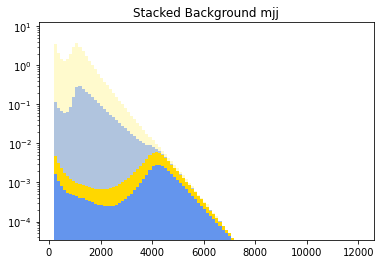

In [17]:
#This part graphs the stacked histogram of the backround into one summed backround
#Darker colors means higher slice, blue is EWK, Yellow is QCD
parameter = "mjj"
mjjData = [EWKSlice4[parameter], QCDSlice4[parameter], EWKSlice3[parameter], QCDSlice3[parameter], EWKSlice2[parameter], QCDSlice2[parameter], EWKSlice1[parameter], QCDSlice1[parameter]]
weightarray = [EWKSlice4["weight"], QCDSlice4["weight"], EWKSlice3["weight"], QCDSlice3["weight"], EWKSlice2["weight"], QCDSlice2["weight"], EWKSlice1["weight"], QCDSlice1["weight"]]
colors = ["navy", "darkorange", "royalblue", "goldenrod", "cornflowerblue", "gold", "lightsteelblue", "lemonchiffon"]
plt.figure()
plt.hist(mjjData, bins=100, range=(200,12000), stacked = True, weights = weightarray, color = colors )
plt.yscale('log')
plt.title("Stacked Background "+parameter)
plt.show()

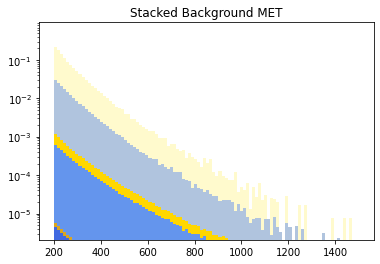

In [18]:
parameter = "MET"
mjjData = [EWKSlice4[parameter], QCDSlice4[parameter], EWKSlice3[parameter], QCDSlice3[parameter], EWKSlice2[parameter], QCDSlice2[parameter], EWKSlice1[parameter], QCDSlice1[parameter]]
weightarray = [EWKSlice4["weight"], QCDSlice4["weight"], EWKSlice3["weight"], QCDSlice3["weight"], EWKSlice2["weight"], QCDSlice2["weight"], EWKSlice1["weight"], QCDSlice1["weight"]]
colors = ["navy", "darkorange", "royalblue", "goldenrod", "cornflowerblue", "gold", "lightsteelblue", "lemonchiffon"]
plt.figure()
plt.hist(mjjData, bins=100, range=(200,1500), stacked = True, weights = weightarray, color = colors )
plt.yscale('log')
plt.title("Stacked Background "+parameter)
plt.show()

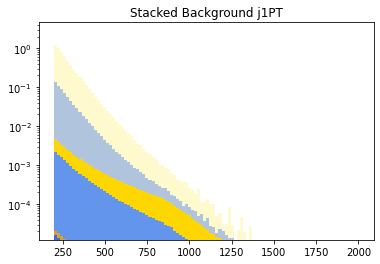

In [19]:
parameter = "j1PT"
mjjData = [EWKSlice4[parameter], QCDSlice4[parameter], EWKSlice3[parameter], QCDSlice3[parameter], EWKSlice2[parameter], QCDSlice2[parameter], EWKSlice1[parameter], QCDSlice1[parameter]]
weightarray = [EWKSlice4["weight"], QCDSlice4["weight"], EWKSlice3["weight"], QCDSlice3["weight"], EWKSlice2["weight"], QCDSlice2["weight"], EWKSlice1["weight"], QCDSlice1["weight"]]
colors = ["navy", "darkorange", "royalblue", "goldenrod", "cornflowerblue", "gold", "lightsteelblue", "lemonchiffon"]
plt.figure()
plt.hist(mjjData, bins=100, range=(200,2000), stacked = True, weights = weightarray, color = colors )
plt.yscale('log')
plt.title("Stacked Background "+parameter)
plt.show()

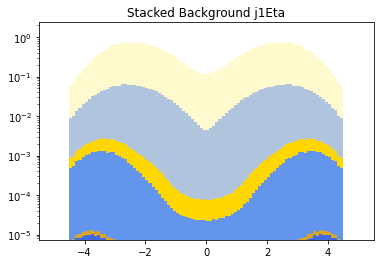

In [20]:
parameter = "j1Eta"
mjjData = [EWKSlice4[parameter], QCDSlice4[parameter], EWKSlice3[parameter], QCDSlice3[parameter], EWKSlice2[parameter], QCDSlice2[parameter], EWKSlice1[parameter], QCDSlice1[parameter]]
weightarray = [EWKSlice4["weight"], QCDSlice4["weight"], EWKSlice3["weight"], QCDSlice3["weight"], EWKSlice2["weight"], QCDSlice2["weight"], EWKSlice1["weight"], QCDSlice1["weight"]]
colors = ["navy", "darkorange", "royalblue", "goldenrod", "cornflowerblue", "gold", "lightsteelblue", "lemonchiffon"]
plt.figure()
plt.hist(mjjData, bins=100, range=(-5,5), stacked = True, weights = weightarray, color = colors )
plt.yscale('log')
plt.title("Stacked Background "+parameter)
plt.show()

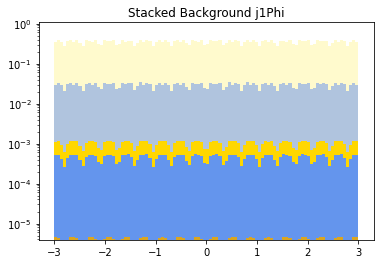

In [21]:
parameter = "j1Phi"
mjjData = [EWKSlice4[parameter], QCDSlice4[parameter], EWKSlice3[parameter], QCDSlice3[parameter], EWKSlice2[parameter], QCDSlice2[parameter], EWKSlice1[parameter], QCDSlice1[parameter]]
weightarray = [EWKSlice4["weight"], QCDSlice4["weight"], EWKSlice3["weight"], QCDSlice3["weight"], EWKSlice2["weight"], QCDSlice2["weight"], EWKSlice1["weight"], QCDSlice1["weight"]]
colors = ["navy", "darkorange", "royalblue", "goldenrod", "cornflowerblue", "gold", "lightsteelblue", "lemonchiffon"]
plt.figure()
plt.hist(mjjData, bins=100, range=(-3,3), stacked = True, weights = weightarray, color = colors )
plt.yscale('log')
plt.title("Stacked Background "+parameter)
plt.show()

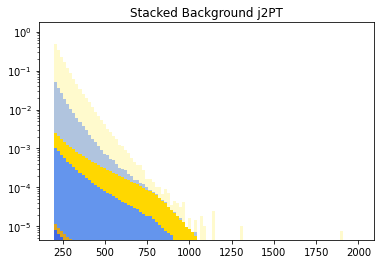

In [22]:
parameter = "j2PT"
mjjData = [EWKSlice4[parameter], QCDSlice4[parameter], EWKSlice3[parameter], QCDSlice3[parameter], EWKSlice2[parameter], QCDSlice2[parameter], EWKSlice1[parameter], QCDSlice1[parameter]]
weightarray = [EWKSlice4["weight"], QCDSlice4["weight"], EWKSlice3["weight"], QCDSlice3["weight"], EWKSlice2["weight"], QCDSlice2["weight"], EWKSlice1["weight"], QCDSlice1["weight"]]
colors = ["navy", "darkorange", "royalblue", "goldenrod", "cornflowerblue", "gold", "lightsteelblue", "lemonchiffon"]
plt.figure()
plt.hist(mjjData, bins=100, range=(200,2000), stacked = True, weights = weightarray, color = colors )
plt.yscale('log')
plt.title("Stacked Background "+parameter)
plt.show()

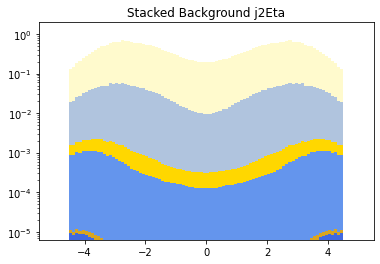

In [23]:
parameter = "j2Eta"
mjjData = [EWKSlice4[parameter], QCDSlice4[parameter], EWKSlice3[parameter], QCDSlice3[parameter], EWKSlice2[parameter], QCDSlice2[parameter], EWKSlice1[parameter], QCDSlice1[parameter]]
weightarray = [EWKSlice4["weight"], QCDSlice4["weight"], EWKSlice3["weight"], QCDSlice3["weight"], EWKSlice2["weight"], QCDSlice2["weight"], EWKSlice1["weight"], QCDSlice1["weight"]]
colors = ["navy", "darkorange", "royalblue", "goldenrod", "cornflowerblue", "gold", "lightsteelblue", "lemonchiffon"]
plt.figure()
plt.hist(mjjData, bins=100, range=(-5,5), stacked = True, weights = weightarray, color = colors )
plt.yscale('log')
plt.title("Stacked Background "+parameter)
plt.show()

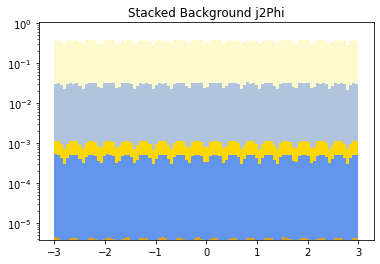

In [24]:
parameter = "j2Phi"
mjjData = [EWKSlice4[parameter], QCDSlice4[parameter], EWKSlice3[parameter], QCDSlice3[parameter], EWKSlice2[parameter], QCDSlice2[parameter], EWKSlice1[parameter], QCDSlice1[parameter]]
weightarray = [EWKSlice4["weight"], QCDSlice4["weight"], EWKSlice3["weight"], QCDSlice3["weight"], EWKSlice2["weight"], QCDSlice2["weight"], EWKSlice1["weight"], QCDSlice1["weight"]]
colors = ["navy", "darkorange", "royalblue", "goldenrod", "cornflowerblue", "gold", "lightsteelblue", "lemonchiffon"]
plt.figure()
plt.hist(mjjData, bins=100, range=(-3,3), stacked = True, weights = weightarray, color = colors )
plt.yscale('log')
plt.title("Stacked Background "+parameter)
plt.show()

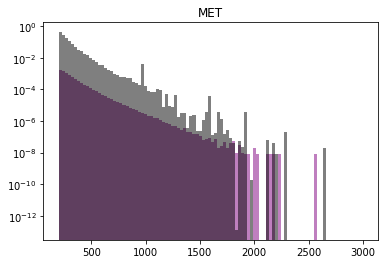

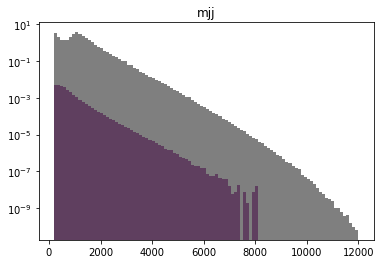

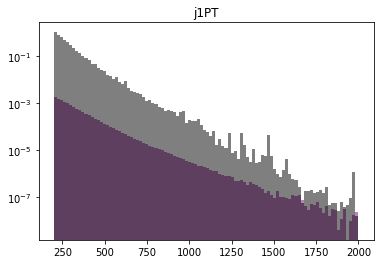

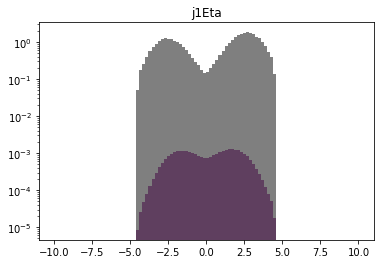

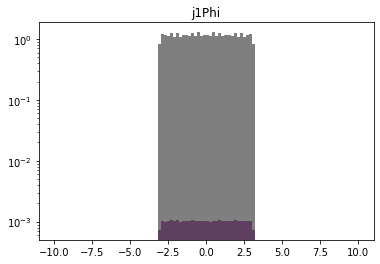

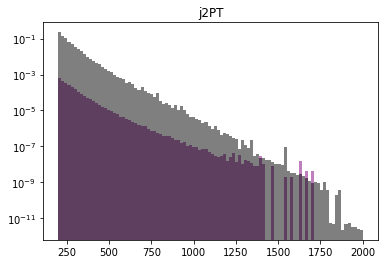

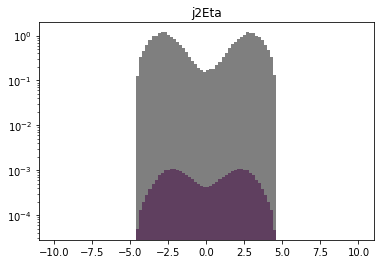

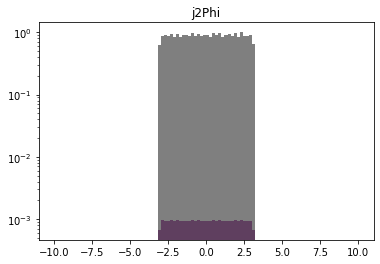

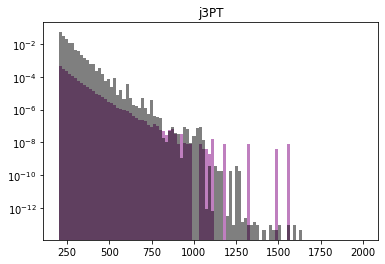

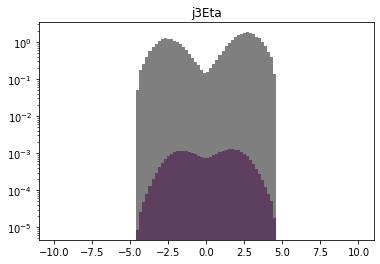

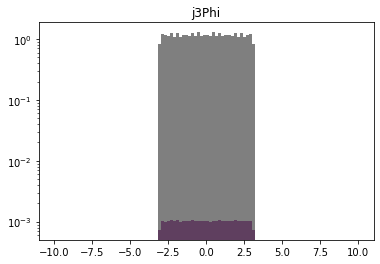

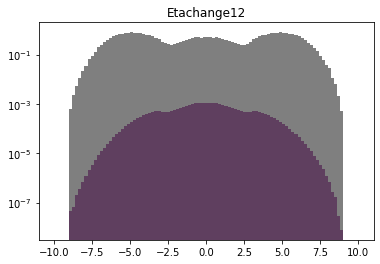

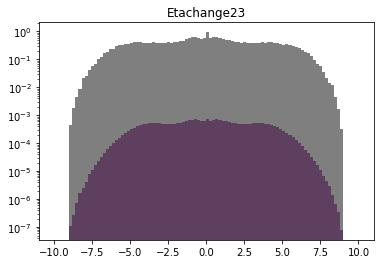

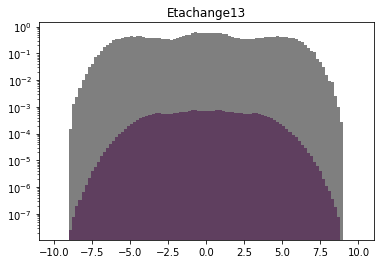

In [12]:
##Plot Graphs
##Feel Free to define these variables above and use these graph presets as a guide.
#MET
plt.hist(S_MET, bins=100, range=(200,3000), weights=S_weight, alpha=0.5, color = 'purple')
plt.hist(B_MET, bins=100, range=(200,3000), weights=B_weight, alpha=0.5, color = 'black')
plt.yscale('log')
plt.title("MET")
plt.show()
#mjj
plt.hist(S_mjj,bins=100,range=(200,12000),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_mjj,bins=100,range=(200,12000),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("mjj")
plt.show()
#j1PT
plt.hist(S_j1PT,bins=100,range=(200,2000),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j1PT,bins=100,range=(200,2000),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j1PT")
plt.show()
#j1Eta
plt.hist(S_j1Eta,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j1Eta,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j1Eta")
plt.show()
#j1Phi
plt.hist(S_j1Phi,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j1Phi,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j1Phi")
plt.show()
#j2PT
plt.hist(S_j2PT,bins=100,range=(200,2000),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j2PT,bins=100,range=(200,2000),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j2PT")
plt.show()
#j2Eta
plt.hist(S_j2Eta,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j2Eta,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j2Eta")
plt.show()
#j2Phi
plt.hist(S_j2Phi,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j2Phi,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j2Phi")
plt.show()
#j3PT
plt.hist(S_j3PT,bins=100,range=(200,2000),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j3PT,bins=100,range=(200,2000),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j3PT")
plt.show()
#j3Eta
plt.hist(S_j3Eta,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j3Eta,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j3Eta")
plt.show()
#j3Phi
plt.hist(S_j3Phi,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j3Phi,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j3Phi")
plt.show()

#Etachange12
plt.hist(S_Etachange12,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_Etachange12,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("Etachange12")
plt.show()
#Etachange23
plt.hist(S_Etachange23,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_Etachange23,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("Etachange23")
plt.show()
#Etachange13
plt.hist(S_Etachange13,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_Etachange13,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("Etachange13")
plt.show()


In [13]:
##Plot Graphs, Optimized Version
#Define Variables to Graph
OS_j1PT = X["j1PT"]
OB_j1PT = np.append(Y["j1PT"],Z["j1PT"])
OS_weight = X["weight"]
OB_weight = np.append(Y["weight"],Z["weight"])
OS_MET = X["MET"]
OB_MET = np.append(Y["MET"],Z["MET"])
OS_mjj = X["mjj"]
OB_mjj = np.append(Y["mjj"],Z["mjj"])
OS_mjjoptimized = X["mjjoptimized"]
OB_mjjoptimized = np.append(Y["mjjoptimized"],Z["mjjoptimized"])
OS_j1Eta = X["j1Eta"]
OB_j1Eta = np.append(Y["j1Eta"],Z["j1Eta"])
OS_j1Phi = X["j1Phi"]
OB_j1Phi = np.append(Y["j1Phi"],Z["j1Phi"])
OS_j2PT = X["j2PT"]
OB_j2PT = np.append(Y["j2PT"],Z["j2PT"])
OS_j2Eta = X["j2Eta"]
OB_j2Eta = np.append(Y["j2Eta"],Z["j2Eta"])
OS_j2Phi = X["j2Phi"]
OB_j2Phi = np.append(Y["j2Phi"],Z["j2Phi"])
#MET
plt.hist(OS_MET, bins=100, range=(200,3000), weights=OS_weight, alpha=0.5, color = 'purple')
plt.hist(OB_MET, bins=100, range=(200,3000), weights=OB_weight, alpha=0.5, color = 'black')
plt.yscale('log')
plt.title("MET")
plt.show()
#mjj
plt.hist(OS_mjj,bins=100,range=(200,12000),weights=OS_weight, alpha=0.5, color='purple')
plt.hist(OB_mjj,bins=100,range=(200,12000),weights=OB_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("mjj")
plt.show()
#j1PT
plt.hist(OS_j1PT,bins=100,range=(200,2000),weights=OS_weight, alpha=0.5, color='purple')
plt.hist(OB_j1PT,bins=100,range=(200,2000),weights=OB_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j1PT")
plt.show()
#j1Eta
plt.hist(OS_j1Eta,bins=100,range=(-10,10),weights=OS_weight, alpha=0.5, color='purple')
plt.hist(OB_j1Eta,bins=100,range=(-10,10),weights=OB_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j1Eta")
plt.show()
#j1Phi
plt.hist(OS_j1Phi,bins=100,range=(-10,10),weights=OS_weight, alpha=0.5, color='purple')
plt.hist(OB_j1Phi,bins=100,range=(-10,10),weights=OB_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j1Phi")
plt.show()
#j2PT
plt.hist(OS_j2PT,bins=100,range=(200,2000),weights=OS_weight, alpha=0.5, color='purple')
plt.hist(OB_j2PT,bins=100,range=(200,2000),weights=OB_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j2PT")
plt.show()
#j2Eta
plt.hist(OS_j2Eta,bins=100,range=(-10,10),weights=OS_weight, alpha=0.5, color='purple')
plt.hist(OB_j2Eta,bins=100,range=(-10,10),weights=OB_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j2Eta")
plt.show()
#j2Phi
plt.hist(OS_j2Phi,bins=100,range=(-10,10),weights=OS_weight, alpha=0.5, color='purple')
plt.hist(OB_j2Phi,bins=100,range=(-10,10),weights=OB_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j2Phi")
plt.show()

NameError: name 'X' is not defined

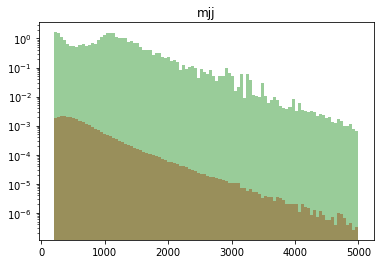

Blue is optimized mjj with max from the 3 jet pairs, red is the standard 1-2 jet calculation
Grey is the optimized mjj for background, green is the standard way of defining background.


In [27]:
#plt.hist(OS_mjjoptimized,bins=100,range=(200,5000),weights=OS_weight, alpha=0.4, color='blue')
#plt.hist(OB_mjjoptimized,bins=100,range=(200,5000),weights=OB_weight, alpha=0.4, color='black')
plt.yscale('log')
plt.title("mjj")

plt.hist(OS_mjj,bins=100,range=(200,5000),weights=OS_weight, alpha=0.4, color='red')
plt.hist(OB_mjj,bins=100,range=(200,5000),weights=OB_weight, alpha=0.4, color='green')
plt.yscale('log')
plt.title("mjj")
plt.show()
print("Blue is optimized mjj with max from the 3 jet pairs, red is the standard 1-2 jet calculation")
print("Grey is the optimized mjj for background, green is the standard way of defining background.")

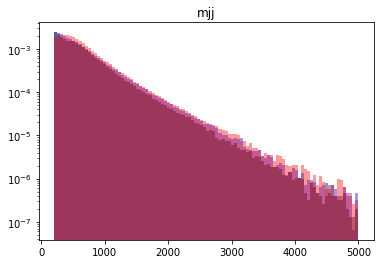

In [30]:
OS_mjj_13 = X["mjj_13"]
OS_mjj_23 = X["mjj_23"]
OB_mjj_13 = np.append(Y["mjj_13"],Z["mjj_13"])
OB_mjj_23 = np.append(Y["mjj_23"],Z["mjj_23"])

plt.hist(OS_mjj_13,bins=100,range=(200,5000),weights=OS_weight, alpha=0.4, color='blue')
plt.hist(OS_mjj_23,bins=100,range=(200,5000),weights=OS_weight, alpha=0.4, color='black')
plt.hist(OS_mjj,bins=100,range=(200,5000),weights=OS_weight, alpha=0.4, color='red')
plt.yscale('log')
plt.title("mjj")
plt.show()

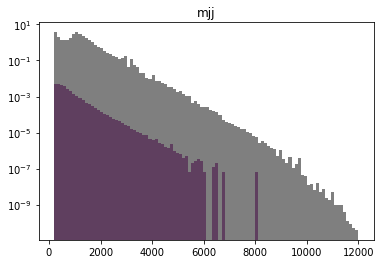

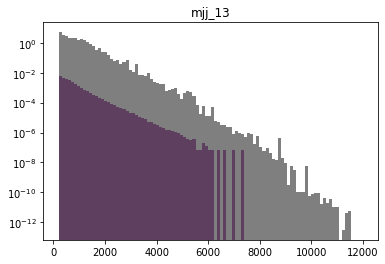

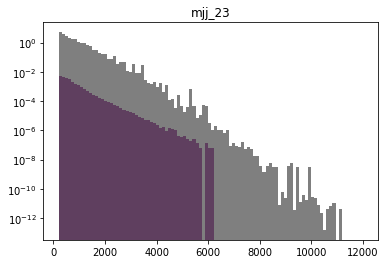

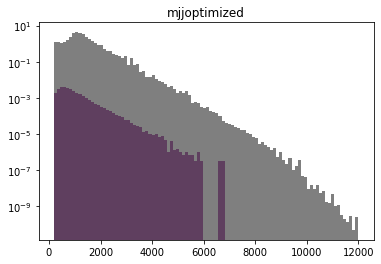

In [31]:
plt.hist(OS_mjj,bins=100,range=(200,12000),weights=OS_weight, alpha=0.5, color='purple')
plt.hist(OB_mjj,bins=100,range=(200,12000),weights=OB_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("mjj")
plt.show()
plt.hist(OS_mjj_13,bins=100,range=(200,12000),weights=OS_weight, alpha=0.5, color='purple')
plt.hist(OB_mjj_13,bins=100,range=(200,12000),weights=OB_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("mjj_13")
plt.show()
plt.hist(OS_mjj_23,bins=100,range=(200,12000),weights=OS_weight, alpha=0.5, color='purple')
plt.hist(OB_mjj_23,bins=100,range=(200,12000),weights=OB_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("mjj_23")
plt.show()
plt.hist(OS_mjjoptimized,bins=100,range=(200,12000),weights=OS_weight, alpha=0.5, color='purple')
plt.hist(OB_mjjoptimized,bins=100,range=(200,12000),weights=OB_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("mjjoptimized")
plt.show()

In [40]:
print(np.mean(OS_mjj))
print(np.mean(OS_mjj_13))
print(np.mean(OS_mjj_23))
print(np.mean(OB_mjj))
print(np.mean(OB_mjj_13))
print(np.mean(OB_mjj_23))

print("comparison, of 12 S/B")
print(np.mean(OS_mjj)/np.mean(OB_mjj))
print("comparison, of 13 S/B")
print(np.mean(OS_mjj_13)/np.mean(OB_mjj_13))
print("comparison, of 23 S/B")
print(np.mean(OS_mjj_23)/np.mean(OB_mjj_23))
print("comparison, of optimized S/B")
print(np.mean(OS_mjjoptimized)/np.mean(OB_mjjoptimized))

635.1876
587.5299
529.3518
3896.3682
1280.7373
843.4048
comparison, of 12 S/B
0.16302043
comparison, of 13 S/B
0.45874348
comparison, of 23 S/B
0.62763673
comparison, of optimized S/B
0.20738001


In [33]:
print(len(X["mjjoptimized"]))
print(len(X["weight"]))
print(len(X["mjj"]))
print(len(Y["mjjoptimized"]))
print(len(Y["weight"]))
print(len(Y["mjj"]))
print(len(Z["mjjoptimized"]))
print(len(Z["weight"]))
print(len(Z["mjj"]))

495546
495546
495546
216036
216036
216036
279613
279613
279613


In [34]:
h = [1,2,3,4,5]
j = [3,4,2,6,9]
k = [1,3,4,2,2]
mix = []
for i in range(len(h)):
    array = []
    array.append(h[i])
    array.append(j[i])
    array.append(k[i])
    mix.append(np.max(array))
print(mix)

[3, 4, 4, 6, 9]


In [35]:
OS_Etachange = X["Etachange"]
OB_Etachange = np.append(Y["Etachange"],Z["Etachange"])

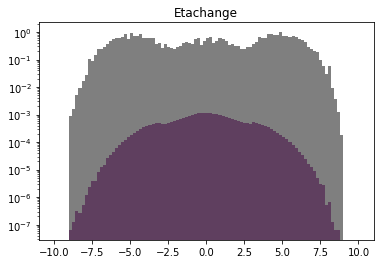

In [36]:
plt.hist(OS_Etachange,bins=100,range=(-10,10),weights=OS_weight, alpha=0.5, color='purple')
plt.hist(OB_Etachange,bins=100,range=(-10,10),weights=OB_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("Etachange")
plt.show()

In [ ]:
j3PT = X["j3PT"]
weight = X["weight"]
plt.hist(j3PT,bins=100,range=(200,2000),weights=weight, alpha=1, color='purple')

plt.yscale('log')
plt.title("j3PT")
plt.show()
j2PT = X["j2PT"]
weight = X["weight"]
plt.hist(j2PT,bins=100,range=(200,2000),weights=weight, alpha=1, color='purple')

plt.yscale('log')
plt.title("j2PT")
plt.show()
j1PT = X["j1PT"]
weight = X["weight"]
plt.hist(j1PT,bins=100,range=(200,2000),weights=weight, alpha=1, color='purple')

plt.yscale('log')
plt.title("j1PT")
plt.show()

In [ ]:
mjj = X["mjj"]
weight = X["weight"]
plt.hist(mjj,bins=100,range=(200,4000),weights=weight, alpha=0.3, color='black')

plt.yscale('log')
plt.title("mjj")

mjj_13 = X["mjj_13"]
weight = X["weight"]
plt.hist(mjj_13,bins=100,range=(200,4000),weights=weight, alpha=0.3, color='red')

plt.yscale('log')
plt.title("mjj_13")

mjj_23 = X["mjj_23"]
weight = X["weight"]
plt.hist(mjj_23,bins=100,range=(200,4000),weights=weight, alpha=0.3, color='blue')

plt.yscale('log')
plt.title("Black-J1,J2. Red-J1,J3. Blue-J2,J3")

mjjoptimized = X["mjjoptimized"]
weight = X["weight"]
plt.hist(mjjoptimized,bins=100,range=(200,4000),weights=weight, alpha=1, color='blue')

plt.yscale('log')
plt.title("Optimized")
plt.show()


mjj = X["mjj"]
weight = X["weight"]
plt.hist(mjj,bins=100,range=(200,4000),weights=weight, alpha=0.3, color='black')

plt.yscale('log')
plt.title("mjj")
plt.show()
mjj_13 = X["mjj_13"]
weight = X["weight"]
plt.hist(mjj_13,bins=100,range=(200,4000),weights=weight, alpha=0.3, color='red')

plt.yscale('log')
plt.title("mjj_13")
plt.show()
mjj_23 = X["mjj_23"]
weight = X["weight"]
plt.hist(mjj_23,bins=100,range=(200,4000),weights=weight, alpha=0.3, color='blue')

plt.yscale('log')
plt.title("mjj_23")
plt.show()
mjjoptimized = X["mjjoptimized"]
weight = X["weight"]
plt.hist(mjjoptimized,bins=100,range=(200,4000),weights=weight, alpha=1, color='blue')

plt.yscale('log')
plt.title("Optimized")
plt.show()

Experiment 1, VBF jets defined by highest total mmjj

In [14]:
EWKBDirect = "/data/users/jupyter-blonsbro/SUSY/EWKBDirect/"
QCDBDirect = "/data/users/jupyter-blonsbro/SUSY/QCDBDirect/"
SignalDirectory = "/data/users/jupyter-blonsbro/SUSY/Generations/13TeV/Signal/150mjj/"
X = Event_Combination(SignalDirectory, Graph = False, optimize = True, METcut = 200)
Y = Background(EWKBDirect, Graph = False, optimize = True, METcut = 200)
Z = Background(QCDBDirect, Graph = False, optimize = True, METcut = 200)

Graph for no slicing scheme
Graph for Slice 1, 1000-4000
Graph for Slice 2, 4000-7000
Graph for Slice 3, 7000-10000
Graph for Slice 4, 10000--1
Graph for Slice 1, 1000-4000
Graph for Slice 2, 4000-7000
Graph for Slice 3, 7000-10000
Graph for Slice 4, 10000--1
File VjjQCD_13_mmjj_10000_-1_1007 Unable to be combined, could not find Cross Section
3


In [15]:
#make graph for Highest mjj value in each
Smjjoptimized_highmass = []
Smjjoptimized_highEtachange = []
Smjjoptimized_highPTProduct = []
Smjjoptimized_highEtaProduct =[]
Smjjoptimized_highPhichange = []
Smjjoptimized_highEtaPhiProduct = []
Smjjoptimized_highDeltaR = []
Bmjjoptimized_highmass = []
Bmjjoptimized_highEtachange = []
Bmjjoptimized_highPTProduct = []
Bmjjoptimized_highEtaProduct =[]
Bmjjoptimized_highPhichange = []
Bmjjoptimized_highEtaPhiProduct = []
Bmjjoptimized_highDeltaR = []

for i in range(len(X["mjj"])):
    if X["VBFJet"][i][0] == [1,2]:
        Smjjoptimized_highmass.append(X["mjj"][i])
    if X["VBFJet"][i][0] == [2,3]:
        Smjjoptimized_highmass.append(X["mjj_23"][i])
    if X["VBFJet"][i][0] == [1,3]:
        Smjjoptimized_highmass.append(X["mjj_13"][i])
    if X["VBFJet"][i][1] == [1,2]:
        Smjjoptimized_highEtachange.append(X["mjj"][i])
    if X["VBFJet"][i][1] == [2,3]:
        Smjjoptimized_highEtachange.append(X["mjj_23"][i])
    if X["VBFJet"][i][1] == [1,3]:
        Smjjoptimized_highEtachange.append(X["mjj_13"][i])
    if X["VBFJet"][i][2] == [1,2]:
        Smjjoptimized_highPTProduct.append(X["mjj"][i])
    if X["VBFJet"][i][2] == [2,3]:
        Smjjoptimized_highPTProduct.append(X["mjj_23"][i])
    if X["VBFJet"][i][2] == [1,3]:
        Smjjoptimized_highPTProduct.append(X["mjj_13"][i])
    if X["VBFJet"][i][3] == [1,2]:
        Smjjoptimized_highEtaProduct.append(X["mjj"][i])
    if X["VBFJet"][i][3] == [2,3]:
        Smjjoptimized_highEtaProduct.append(X["mjj_23"][i])
    if X["VBFJet"][i][3] == [1,3]:
        Smjjoptimized_highEtaProduct.append(X["mjj_13"][i])
    if X["VBFJet"][i][4] == [1,2]:
        Smjjoptimized_highPhichange.append(X["mjj"][i])
    if X["VBFJet"][i][4] == [2,3]:
        Smjjoptimized_highPhichange.append(X["mjj_23"][i])
    if X["VBFJet"][i][4] == [1,3]:
        Smjjoptimized_highPhichange.append(X["mjj_13"][i])
    if X["VBFJet"][i][5] == [1,2]:
        Smjjoptimized_highDeltaR.append(X["mjj"][i])
    if X["VBFJet"][i][5] == [2,3]:
        Smjjoptimized_highDeltaR.append(X["mjj_23"][i])
    if X["VBFJet"][i][5] == [1,3]:
        Smjjoptimized_highDeltaR.append(X["mjj_13"][i])
for i in range(len(Y["mjj"])):
    if Y["VBFJet"][i][0] == [1,2]:
        Bmjjoptimized_highmass.append(Y["mjj"][i])
    if Y["VBFJet"][i][0] == [2,3]:
        Bmjjoptimized_highmass.append(Y["mjj_23"][i])
    if Y["VBFJet"][i][0] == [1,3]:
        Bmjjoptimized_highmass.append(Y["mjj_13"][i])
    if Y["VBFJet"][i][1] == [1,2]:
        Bmjjoptimized_highEtachange.append(Y["mjj"][i])
    if Y["VBFJet"][i][1] == [2,3]:
        Bmjjoptimized_highEtachange.append(Y["mjj_23"][i])
    if Y["VBFJet"][i][1] == [1,3]:
        Bmjjoptimized_highEtachange.append(Y["mjj_13"][i])
    if Y["VBFJet"][i][2] == [1,2]:
        Bmjjoptimized_highPTProduct.append(Y["mjj"][i])
    if Y["VBFJet"][i][2] == [2,3]:
        Bmjjoptimized_highPTProduct.append(Y["mjj_23"][i])
    if Y["VBFJet"][i][2] == [1,3]:
        Bmjjoptimized_highPTProduct.append(Y["mjj_13"][i])
    if Y["VBFJet"][i][3] == [1,2]:
        Bmjjoptimized_highEtaProduct.append(Y["mjj"][i])
    if Y["VBFJet"][i][3] == [2,3]:
        Bmjjoptimized_highEtaProduct.append(Y["mjj_23"][i])
    if Y["VBFJet"][i][3] == [1,3]:
        Bmjjoptimized_highEtaProduct.append(Y["mjj_13"][i])
    if Y["VBFJet"][i][4] == [1,2]:
        Bmjjoptimized_highPhichange.append(Y["mjj"][i])
    if Y["VBFJet"][i][4] == [2,3]:
        Bmjjoptimized_highPhichange.append(Y["mjj_23"][i])
    if Y["VBFJet"][i][4] == [1,3]:
        Bmjjoptimized_highPhichange.append(Y["mjj_13"][i])
    if Y["VBFJet"][i][5] == [1,2]:
        Bmjjoptimized_highDeltaR.append(Y["mjj"][i])
    if Y["VBFJet"][i][5] == [2,3]:
        Bmjjoptimized_highDeltaR.append(Y["mjj_23"][i])
    if Y["VBFJet"][i][5] == [1,3]:
        Bmjjoptimized_highDeltaR.append(Y["mjj_13"][i])
for i in range(len(Z["mjj"])):
    if Z["VBFJet"][i][0] == [1,2]:
        Bmjjoptimized_highmass.append(Z["mjj"][i])
    if Z["VBFJet"][i][0] == [2,3]:
        Bmjjoptimized_highmass.append(Z["mjj_23"][i])
    if Z["VBFJet"][i][0] == [1,3]:
        Bmjjoptimized_highmass.append(Z["mjj_13"][i])
    if Z["VBFJet"][i][1] == [1,2]:
        Bmjjoptimized_highEtachange.append(Z["mjj"][i])
    if Z["VBFJet"][i][1] == [2,3]:
        Bmjjoptimized_highEtachange.append(Z["mjj_23"][i])
    if Z["VBFJet"][i][1] == [1,3]:
        Bmjjoptimized_highEtachange.append(Z["mjj_13"][i])
    if Z["VBFJet"][i][2] == [1,2]:
        Bmjjoptimized_highPTProduct.append(Z["mjj"][i])
    if Z["VBFJet"][i][2] == [2,3]:
        Bmjjoptimized_highPTProduct.append(Z["mjj_23"][i])
    if Z["VBFJet"][i][2] == [1,3]:
        Bmjjoptimized_highPTProduct.append(Z["mjj_13"][i])
    if Z["VBFJet"][i][3] == [1,2]:
        Bmjjoptimized_highEtaProduct.append(Z["mjj"][i])
    if Z["VBFJet"][i][3] == [2,3]:
        Bmjjoptimized_highEtaProduct.append(Z["mjj_23"][i])
    if Z["VBFJet"][i][3] == [1,3]:
        Bmjjoptimized_highEtaProduct.append(Z["mjj_13"][i])
    if Z["VBFJet"][i][4] == [1,2]:
        Bmjjoptimized_highPhichange.append(Z["mjj"][i])
    if Z["VBFJet"][i][4] == [2,3]:
        Bmjjoptimized_highPhichange.append(Z["mjj_23"][i])
    if Z["VBFJet"][i][4] == [1,3]:
        Bmjjoptimized_highPhichange.append(Z["mjj_13"][i])
    if Z["VBFJet"][i][5] == [1,2]:
        Bmjjoptimized_highDeltaR.append(Y["mjj"][i])
    if Z["VBFJet"][i][5] == [2,3]:
        Bmjjoptimized_highDeltaR.append(Y["mjj_23"][i])
    if Z["VBFJet"][i][5] == [1,3]:
        Bmjjoptimized_highDeltaR.append(Y["mjj_13"][i])

In [16]:
S_weight = X["weight"]
B_weight = np.append(Y["weight"],Z["weight"])

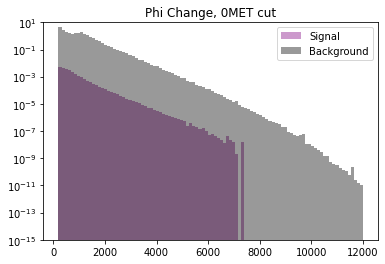

In [17]:
plt.hist(Smjjoptimized_highPhichange,bins=100,range=(200,12000),weights=S_weight, alpha=0.4, color='purple',label = "Signal")
plt.hist(Bmjjoptimized_highPhichange,bins=100,range=(200,12000),weights=B_weight, alpha=0.4, color='black', label = "Background")
plt.yscale('log')
plt.ylim(10**-15,10)
plt.title("Phi Change, 200MET cut")
plt.legend()
plt.show()

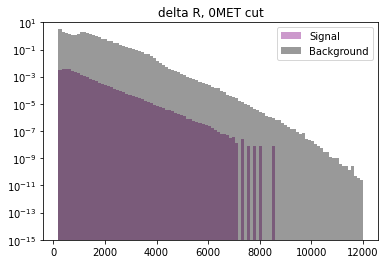

In [18]:
plt.hist(Smjjoptimized_highDeltaR,bins=100,range=(200,12000),weights=S_weight, alpha=0.4, color='purple',label = "Signal")
plt.hist(Bmjjoptimized_highDeltaR,bins=100,range=(200,12000),weights=B_weight, alpha=0.4, color='black', label = "Background")
plt.yscale('log')
plt.ylim(10**-15,10)
plt.title("delta R, 200MET cut")
plt.legend()
plt.show()

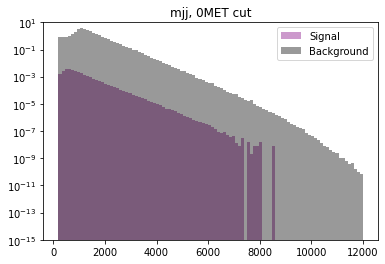

In [19]:
plt.hist(Smjjoptimized_highmass,bins=100,range=(200,12000),weights=S_weight, alpha=0.4, color='purple',label = "Signal")
plt.hist(Bmjjoptimized_highmass,bins=100,range=(200,12000),weights=B_weight, alpha=0.4, color='black', label = "Background")
plt.yscale('log')
plt.ylim(10**-15,10)
plt.title("mjj, 200MET cut")
plt.legend()
plt.show()

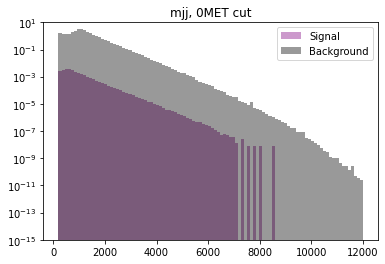

In [20]:
plt.hist(Smjjoptimized_highEtachange,bins=100,range=(200,12000),weights=S_weight, alpha=0.4, color='purple',label = "Signal")
plt.hist(Bmjjoptimized_highEtachange,bins=100,range=(200,12000),weights=B_weight, alpha=0.4, color='black', label = "Background")
plt.yscale('log')
plt.ylim(10**-15,10)
plt.title("Etachange, 200MET cut")
plt.legend()
plt.show()

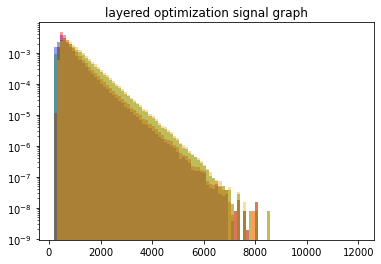

In [115]:
plt.hist(Smjjoptimized_highEtaProduct,bins=100,range=(200,12000),weights=S_weight, alpha=0.4, color='blue')
plt.hist(Smjjoptimized_highPTProduct,bins=100,range=(200,12000),weights=S_weight, alpha=0.4, color='red')
plt.hist(Smjjoptimized_highEtachange,bins=100,range=(200,12000),weights=S_weight, alpha=0.4, color='green')
plt.hist(Smjjoptimized_highmass,bins=100,range=(200,12000),weights=S_weight, alpha=0.4, color='orange')
plt.hist(Smjjoptimized_highEtaPhiProduct,bins=100,range=(200,12000),weights=S_weight, alpha=0.4, color='purple')
plt.hist(Smjjoptimized_highPhichange,bins=100,range=(200,12000),weights=S_weight, alpha=0.4, color='black')
plt.yscale('log')
plt.title("layered optimization signal graph")
plt.show()

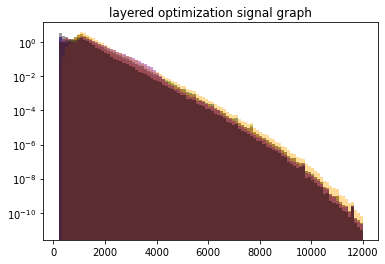

In [36]:
plt.hist(Bmjjoptimized_highEtaProduct,bins=100,range=(200,12000),weights=B_weight, alpha=0.4, color='blue')
plt.hist(Bmjjoptimized_highPTProduct,bins=100,range=(200,12000),weights=B_weight, alpha=0.4, color='red')
plt.hist(Bmjjoptimized_highEtachange,bins=100,range=(200,12000),weights=B_weight, alpha=0.4, color='green')
plt.hist(Bmjjoptimized_highmass,bins=100,range=(200,12000),weights=B_weight, alpha=0.4, color='orange')
plt.hist(Bmjjoptimized_highEtaPhiProduct,bins=100,range=(200,12000),weights=B_weight, alpha=0.4, color='purple')
plt.hist(Bmjjoptimized_highPhichange,bins=100,range=(200,12000),weights=B_weight, alpha=0.4, color='black')
plt.yscale('log')
plt.title("layered optimization signal graph")
plt.show()

In [35]:

high = np.sort([1,4,2])
print(high)
print(high[-2])

[1 2 4]
2
